# Import libraries and set configs

In [1]:
from typing import Union, Tuple

import sys
sys.path.append("..")

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

from colorama import Style, Fore

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval

from dotenv import load_dotenv, find_dotenv
# here we load environment variables from .env, must be called before init. class
load_dotenv(find_dotenv('../.env'), verbose=True)

# Set environment variable
environ["ENV"] = "optimize"

tv_username = os.getenv("TV_USERNAME")
tv_password = os.getenv("TV_PASSWORD")

class CFG:
    load = False
    historical = False
    create_dataset = True
    update_dataset = False
    cls_target_ratio_tp = 1.08
    cls_target_ratio_sl = 1.05
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 272
    # for how long time (in hours) we want to predict
    target_offset = 128
    ttype = "both"
    patterns_to_filter = ["STOCH_RSI_Volume24"]
    select_features = False
    optimize = False
    optimize_alpha = 0.2
    n_repeats = 1
    n_folds = 8
    min_precision = 0.5
    last_date = datetime.strptime("2024-09-16:12:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

tqdm.pandas()

warnings.simplefilter(action="ignore", category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "buy"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "sell"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob("../optimizer/ticker_dataframes/*_1h.pkl")
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df["time"].diff()[1:].nunique()
    if nunique > 1:
        count = df[df["time"].diff().astype("timedelta64[h]") != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + "4h.pkl")
            
counter

  0%|          | 0/3909 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

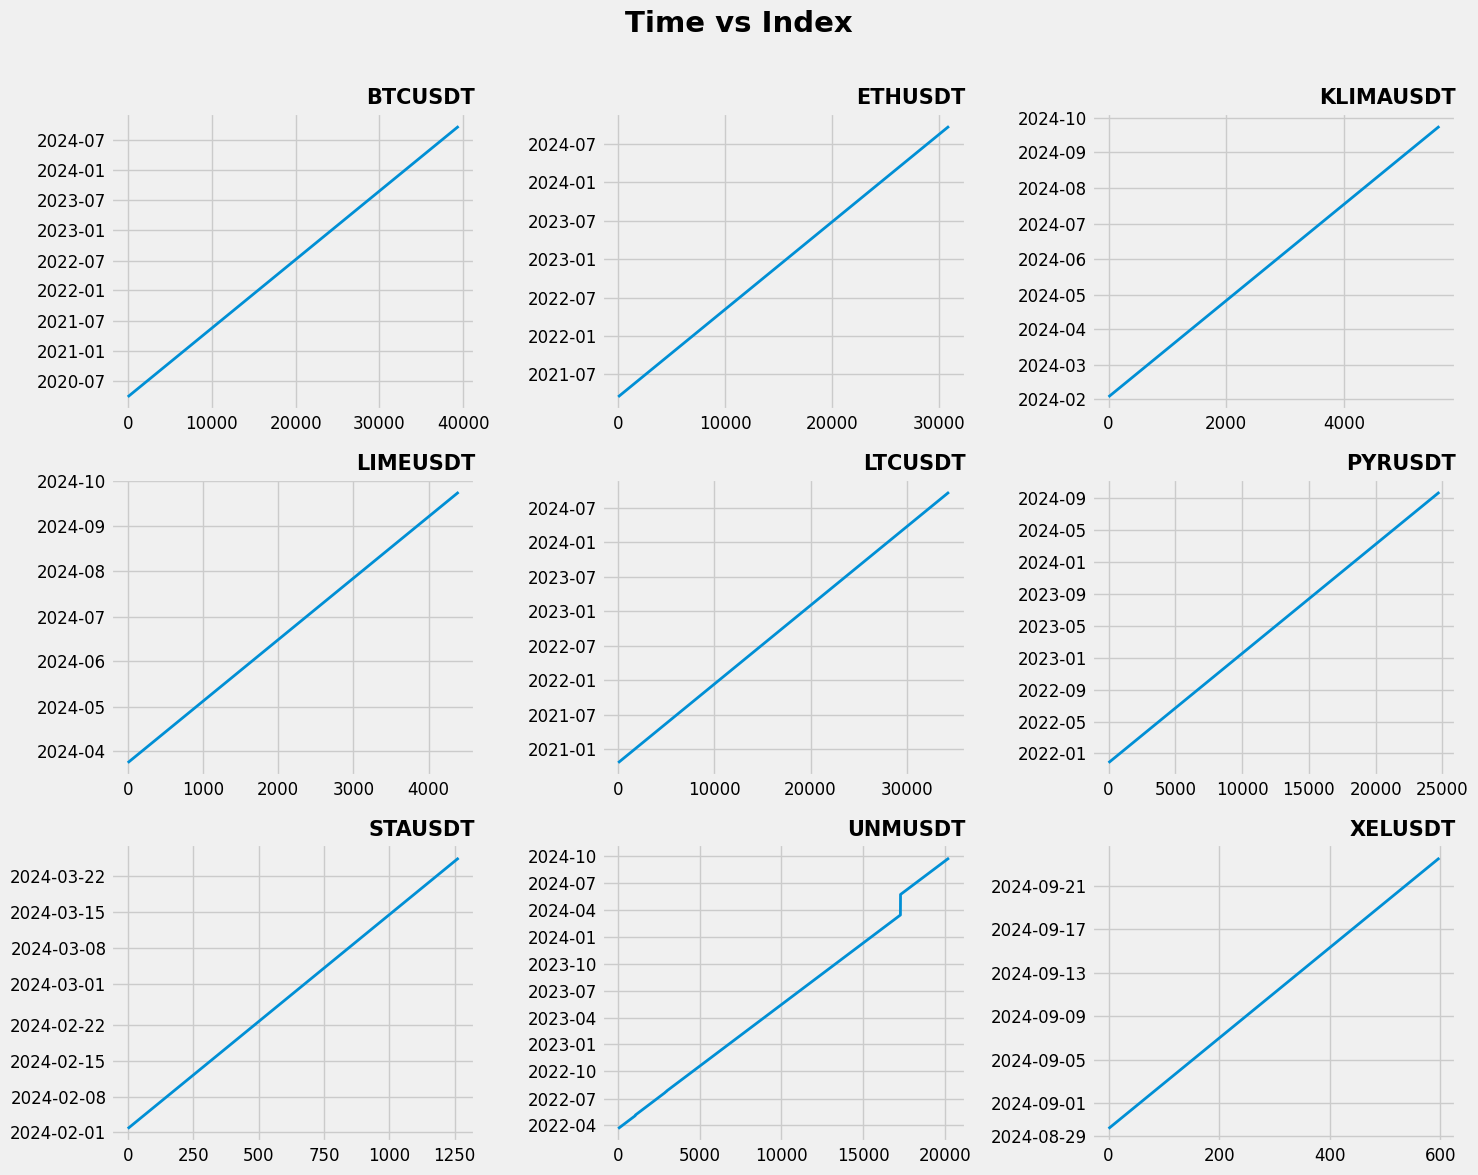

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob("../optimizer/ticker_dataframes/*_1h.pkl")
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if "/BTCUSDT_1h" in t or "/ETHUSDT_1h" in t or "/LTCUSDT_1h" in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df["time"])

        ax.set_ylabel("")
        plt.yticks(fontsize=12) 
        ax.set_xlabel("")
        plt.xticks(fontsize=12)
        # ax.spines["right"].set_visible(False)
        ax.set_title(f"{random_tickers[idx].split('/')[-1][:-7]}", loc="right", weight="bold", fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f"Time vs Index\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob("../optimizer/ticker_dataframes/*.pkl")
y = [i[31:].split("_")[0] for i in x]
z = ("").join(x)

for i in y:
    if f"{i}_1h" not in z:
        print(i, "1h")
    if f"{i}_4h" not in z:
        print(i, "4h")

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ["time", "linear_reg", "linear_reg_angle", "macd", "macdhist", "macdsignal"]
price_cols = ["open","high", "low", "close"]
real_price_cols = ["real_high", "real_low", "real_close"]
funding_cols = ["funding_rate"]
rsi_stoch_cols = ["rsi", "stoch_diff", "stoch_slowd", "stoch_slowk"]
btcd_cols = ["time", "btcd_open", "btcd_high", "btcd_low", "btcd_close", "btcd_volume"]
btcdom_cols = ["time", "btcdom_open", "btcdom_high", "btcdom_low", "btcdom_close", "btcdom_volume"]

def get_file(ticker):
    """ Find files buy ticker names """
    try:
        tmp_df_1h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
        tmp_df_4h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h


def add_indicators(df: pd.DataFrame, df_higher: pd.DataFrame, ttype: str, configs: dict) -> pd.DataFrame:
    """Create indicators and add them to the dataset"""
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, "", "", 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, "", "", 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, "", "", 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, "", "", 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, "", "", 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, "", "", 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, "", "", 0)
    # merge higher timeframe indicators with working timeframe
    df_higher["time"] = df_higher["time"] + pd.to_timedelta(3, unit="h")
    df[higher_features] = pd.merge(df[["time"]], df_higher[higher_features], how="left", on="time")
    df = df.drop(columns=["close_smooth"])
    df = df.drop(columns=[c for c in df.columns if c.endswith("_dir")])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[["time"]], btcd[btcd_cols], how="left", on="time")
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[["time"]], btcdom[btcdom_cols], how="left", on="time")
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[["high", "low", "close"]]
    cols_to_scale = ["open", "high", "low", "close", "macd", "macdhist", "macdsignal", "atr"]
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ["close", "btcd_close", "btcdom_close"]:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f"{col}_{agg_func.__name__}_{period}"] = df[col].rolling(period, min_periods=1).agg({"func": agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    """ Create train dataset from signal statistics and ticker candle data"""
    train_df = list()
    tickers = df["ticker"].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df["ticker"] == ticker]
        times = signal_df["time"]
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev["ticker"] == ticker, "time"].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f"TypeError, ticker - {ticker}")
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc("pattern")]
            row = tmp_df_1h.loc[tmp_df_1h["time"] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h["time"] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f"_prev_{i}" for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row["ticker"] = ticker
                row["pattern"] = pattern
                
            if pass_cycle:
                continue

            row["target"] = 0
            row["max_price_deviation"] = 0
            row["first_price"] = 0
            row["last_price"] = 0
            row["ttype"] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith("MACD"):
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t + timedelta(hours=3), "real_close"]
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t, "real_close"]
            

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue

            row["first_price"] = close_price.values[0]
            row["close_time"] = row["time"].values[0] + pd.to_timedelta(target_offset, unit="h")
            
            close_price = close_price.values[0]
            if ttype == "buy":
                higher_price = close_price * CFG.cls_target_ratio_sl
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
            else:
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_sl)
            
            target_buys, target_sells = [], []
            for i in range(1, target_offset + 1):
                
                if pattern.startswith("MACD"):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_high"]
                target_sell = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_low"]
                
                target_buys.append(target_buy)
                target_sells.append(target_sell)
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set TPs and SLs
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row["pattern"].values[0]
                ttype = row["ttype"].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith("STOCH") and ttype == "buy" and target_buy_sl == 1
                sl2 = pattern.startswith("STOCH") and ttype == "sell" and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith("STOCH") and ttype == "buy" and target_sell_tp == 1
                tp2 = pattern.startswith("STOCH") and ttype == "sell" and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                elif sl1 or sl2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    break
                elif tp1 or tp2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    if row["close_time"].values[0] == row["time"].values[0] + pd.to_timedelta(target_offset, unit="h"):
                        row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    row["target"] = 1
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_close"].values[0]
                    l1 = pattern.startswith("STOCH") and ttype == "buy" and last_price < close_price
                    l2 = pattern.startswith("STOCH") and ttype == "sell" and last_price > close_price
                    # if price doesn't reach both TP and SL - write its last price
                    if row["target"].values[0] == 0:
                        row["last_price"] = last_price

                    if l1 or l2:
                        row["target"] = 1

                # set the maximum price deviation to the correct side for the current trade period 
                if ttype == "sell":
                    curr_price = (target_buy - close_price) / close_price
                else:
                    curr_price = (close_price - target_sell) / close_price
                
                row["max_price_deviation"] = max(row["max_price_deviation"].values[0], curr_price) 
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            train_df.append(row)
    
    train_df = pd.concat(train_df).reset_index(drop=True)
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist("BTC.D","CRYPTOCAP", interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns="symbol")
    btcd.columns = btcd_cols
    btcd["time"] = btcd["time"] + pd.to_timedelta(23, unit="h")

    btcdom = tv.get_hist("BTCDOMUSDT.P","BINANCE", interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns="symbol")
    btcdom.columns = btcdom_cols
    btcdom["time"] = btcdom["time"] + pd.to_timedelta(3, unit="h")
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0] #, 1, 2, 3, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    df = df[df["time"].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, "buy", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [5] #, 8, 9, 11, 14, 17]
    df = df[df["time"].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, "sell", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, "buy", configs, CFG.target_offset, first, CFG.last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values("time").reset_index(drop=True)

    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, "sell", configs, CFG.target_offset, first, CFG.last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values("time").reset_index(drop=True)

    del df

error while signin
you are using nologin method, data you access may be limited


  0%|          | 0/1103 [00:00<?, ?it/s]

### Create train dataset

In [ ]:
train_buy = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
train_sell = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values("time")

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df["time"] < train_df["time"].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if "prev" not in c and "sar" in c]

# Data tests

### Test train dataframe columns

  0%|          | 0/98226 [00:00<?, ?it/s]

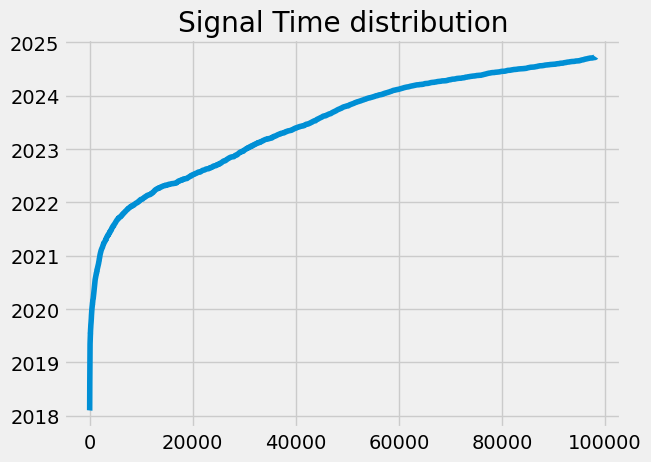

In [ ]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r"_prev_\d+", "", c) for c in train_buy.columns)

    agg_funcs = ["amin", "amax", "mean", "median", "std"]
    agg_cols = [c for c in cols if len(c.split("_")) > 2 and c.split("_")[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ["atr", "cci", "sar", "volume", "pattern", "target", "max_price_deviation", "ticker", "ttype", "close_time", "first_price", "last_price"])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ("rsi" in c or "stoch" in c) and "diff" not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if "volume" in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith("funding")]
    for f_c in funding_cols_:
        num = "".join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith("btcd_") and "volume" not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = "".join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = "".join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # check if columns that were added for backtest and statistics are correct
    for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
        if row["last_price"] > 0:
            assert row["close_time"] - row["time"] == pd.to_timedelta(CFG.target_offset, unit="h")
            assert round(row["max_price_deviation"], 8) <= CFG.cls_target_ratio_tp - 1
        else:
            assert row["close_time"] - row["time"] <= pd.to_timedelta(CFG.target_offset, unit="h")
            if row["target"] == 1:
                assert round(row["max_price_deviation"], 8) >= CFG.cls_target_ratio_tp - 1
            else:
                assert round(row["max_price_deviation"], 8) < CFG.cls_target_ratio_tp - 1

    # plot time values 
    train_df["time"].plot(title="Signal Time distribution")


### Test buy target corectness

In [ ]:
prev_ticker = None

train_buy_ = train_buy[train_buy["ticker"] == "MILOUSDT"]

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]
        if ticker != "MILOUSDT":
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        
        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

  0%|          | 0/56404 [00:00<?, ?it/s]

### Test sell target corectness

In [ ]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target, ttype = y["pattern"], y["ticker"], y["time"], y["target"], y["ttype"]

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        if ttype == "buy":
            low_price = close_price * (2 - CFG.cls_target_ratio_sl)
            high_price = close_price * CFG.cls_target_ratio_tp
        else:
            low_price = close_price * (2 - CFG.cls_target_ratio_tp)
            high_price = close_price * CFG.cls_target_ratio_sl
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]

        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/41823 [00:00<?, ?it/s]

### Test pattern / target distribution

In [ ]:
beta = 0.45
0.8 * 0.8 * beta - 0.5 * (1 - beta)

0.013000000000000067

In [ ]:
def q10(x):
    return x.quantile(0.1)

def q20(x):
    return x.quantile(0.2)

def q30(x):
    return x.quantile(0.3)

def q90(x):
    return x.quantile(0.9)

def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row["total"], row["count"]
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy[(train_buy["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Buy")
display(pvt)
display(train_buy["ttype"].value_counts())
display(train_buy[["target", "pattern"]].value_counts())
display(train_buy[["target", "pattern"]].value_counts(normalize=True))

pvt = train_sell[(train_sell["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Sell")
display(pvt)
display(train_sell["ttype"].value_counts())
display(train_sell[["target", "pattern"]].value_counts())
display(train_sell[["target", "pattern"]].value_counts(normalize=True))

Buy


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.158815,0.069229,0.092125,0.111842,0.337146,1306,2294,0.569311,"(0.5492, 0.5895)"
3,1,1,0.146597,0.062264,0.085661,0.100579,0.353260,1457,2612,0.557810,"(0.5389, 0.5768)"
5,2,1,0.147368,0.057320,0.080031,0.097949,0.327139,1533,2830,0.541696,"(0.5234, 0.56)"
7,3,1,0.140064,0.060561,0.082932,0.098000,0.316300,1835,3189,0.575415,"(0.5583, 0.5925)"
9,4,1,0.136511,0.062426,0.083271,0.099705,0.323659,1594,3089,0.516025,"(0.4985, 0.5336)"
11,5,1,0.142581,0.060132,0.083752,0.100973,0.333783,1343,2618,0.512987,"(0.4939, 0.532)"
13,6,1,0.146635,0.064444,0.086440,0.102678,0.340774,1175,2439,0.481755,"(0.462, 0.5015)"
15,7,1,0.134914,0.066036,0.084719,0.096459,0.305974,1039,2164,0.480129,"(0.4592, 0.5011)"
17,8,1,0.138451,0.067720,0.086420,0.101912,0.368098,991,2151,0.460716,"(0.4398, 0.4817)"
19,9,1,0.133409,0.058221,0.082088,0.096735,0.355441,1053,2132,0.493902,"(0.4728, 0.515)"


buy    56404
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    29190
0       STOCH_RSI_Volume24    27214
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.517516
0       STOCH_RSI_Volume24    0.482484
dtype: float64

Sell


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.146944,0.076847,0.090029,0.102962,0.460049,584,1203,0.485453,"(0.4574, 0.5136)"
3,1,1,0.139964,0.059531,0.086548,0.100618,0.427771,690,1427,0.483532,"(0.4577, 0.5093)"
5,2,1,0.129089,0.056282,0.082242,0.095101,0.359033,1026,1985,0.516877,"(0.495, 0.5387)"
7,3,1,0.133117,0.057489,0.085477,0.098579,0.417568,1153,2271,0.507706,"(0.4872, 0.5282)"
9,4,1,0.137741,0.057163,0.082653,0.096752,0.425234,1165,2244,0.519162,"(0.4986, 0.5397)"
11,5,1,0.142767,0.068140,0.088282,0.101941,0.468827,1220,2316,0.526770,"(0.5065, 0.547)"
13,6,1,0.133369,0.063878,0.085522,0.100939,0.418259,1171,2206,0.530825,"(0.5101, 0.5515)"
15,7,1,0.147706,0.066620,0.089796,0.107987,0.413834,1225,2278,0.537752,"(0.5174, 0.5581)"
17,8,1,0.139533,0.063526,0.085181,0.101576,0.420767,1052,1954,0.538383,"(0.5164, 0.5604)"
19,9,1,0.146959,0.069717,0.088893,0.103692,0.418784,985,1828,0.538840,"(0.5161, 0.5616)"


sell    41823
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    21803
0       STOCH_RSI_Volume24    20020
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.521316
0       STOCH_RSI_Volume24    0.478684
dtype: float64

# Data visualization

### Plot ratio of class 1 for every week day

Monday = 0, Sunday = 6

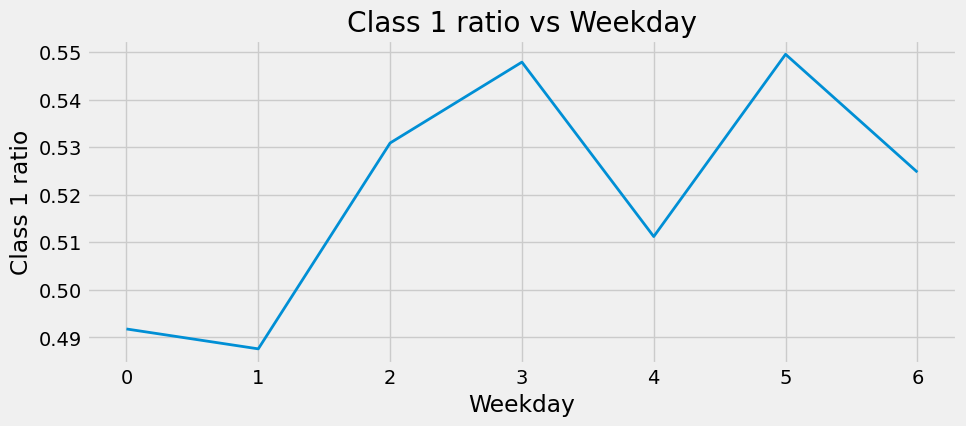

In [26]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["weekday"] = group_df["time"].dt.weekday
ax = group_df.groupby("weekday")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Weekday")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Weekday");

### Plot ratio of class 1 for every month

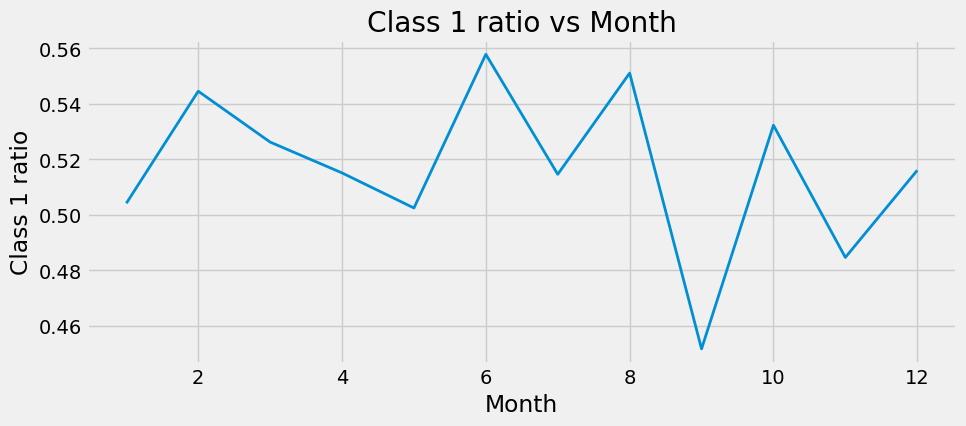

In [27]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["month"] = group_df["time"].dt.month
ax = group_df.groupby("month")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Month")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Month");

### Plot ratio of class 1 for every day of last months

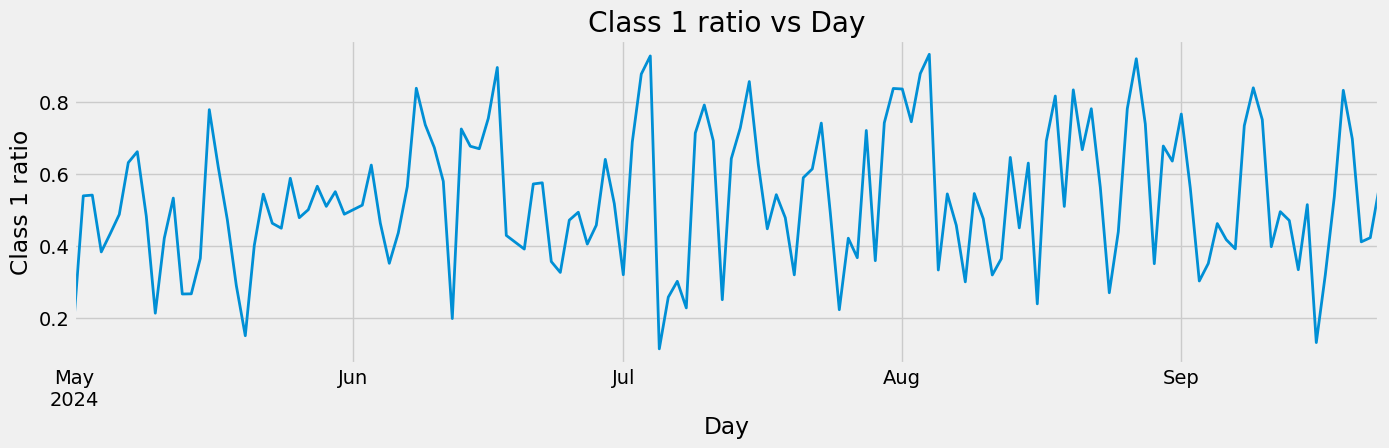

In [28]:
plt.figure(figsize=(15, 4))

group_df = train_df[(train_df["time"].dt.year >= 2024) & (train_df["time"].dt.month >= 5)]
group_df["day"] = group_df["time"].dt.to_period("D")
ax = group_df.groupby("day")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Day")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Day");

### Visualize buy trades

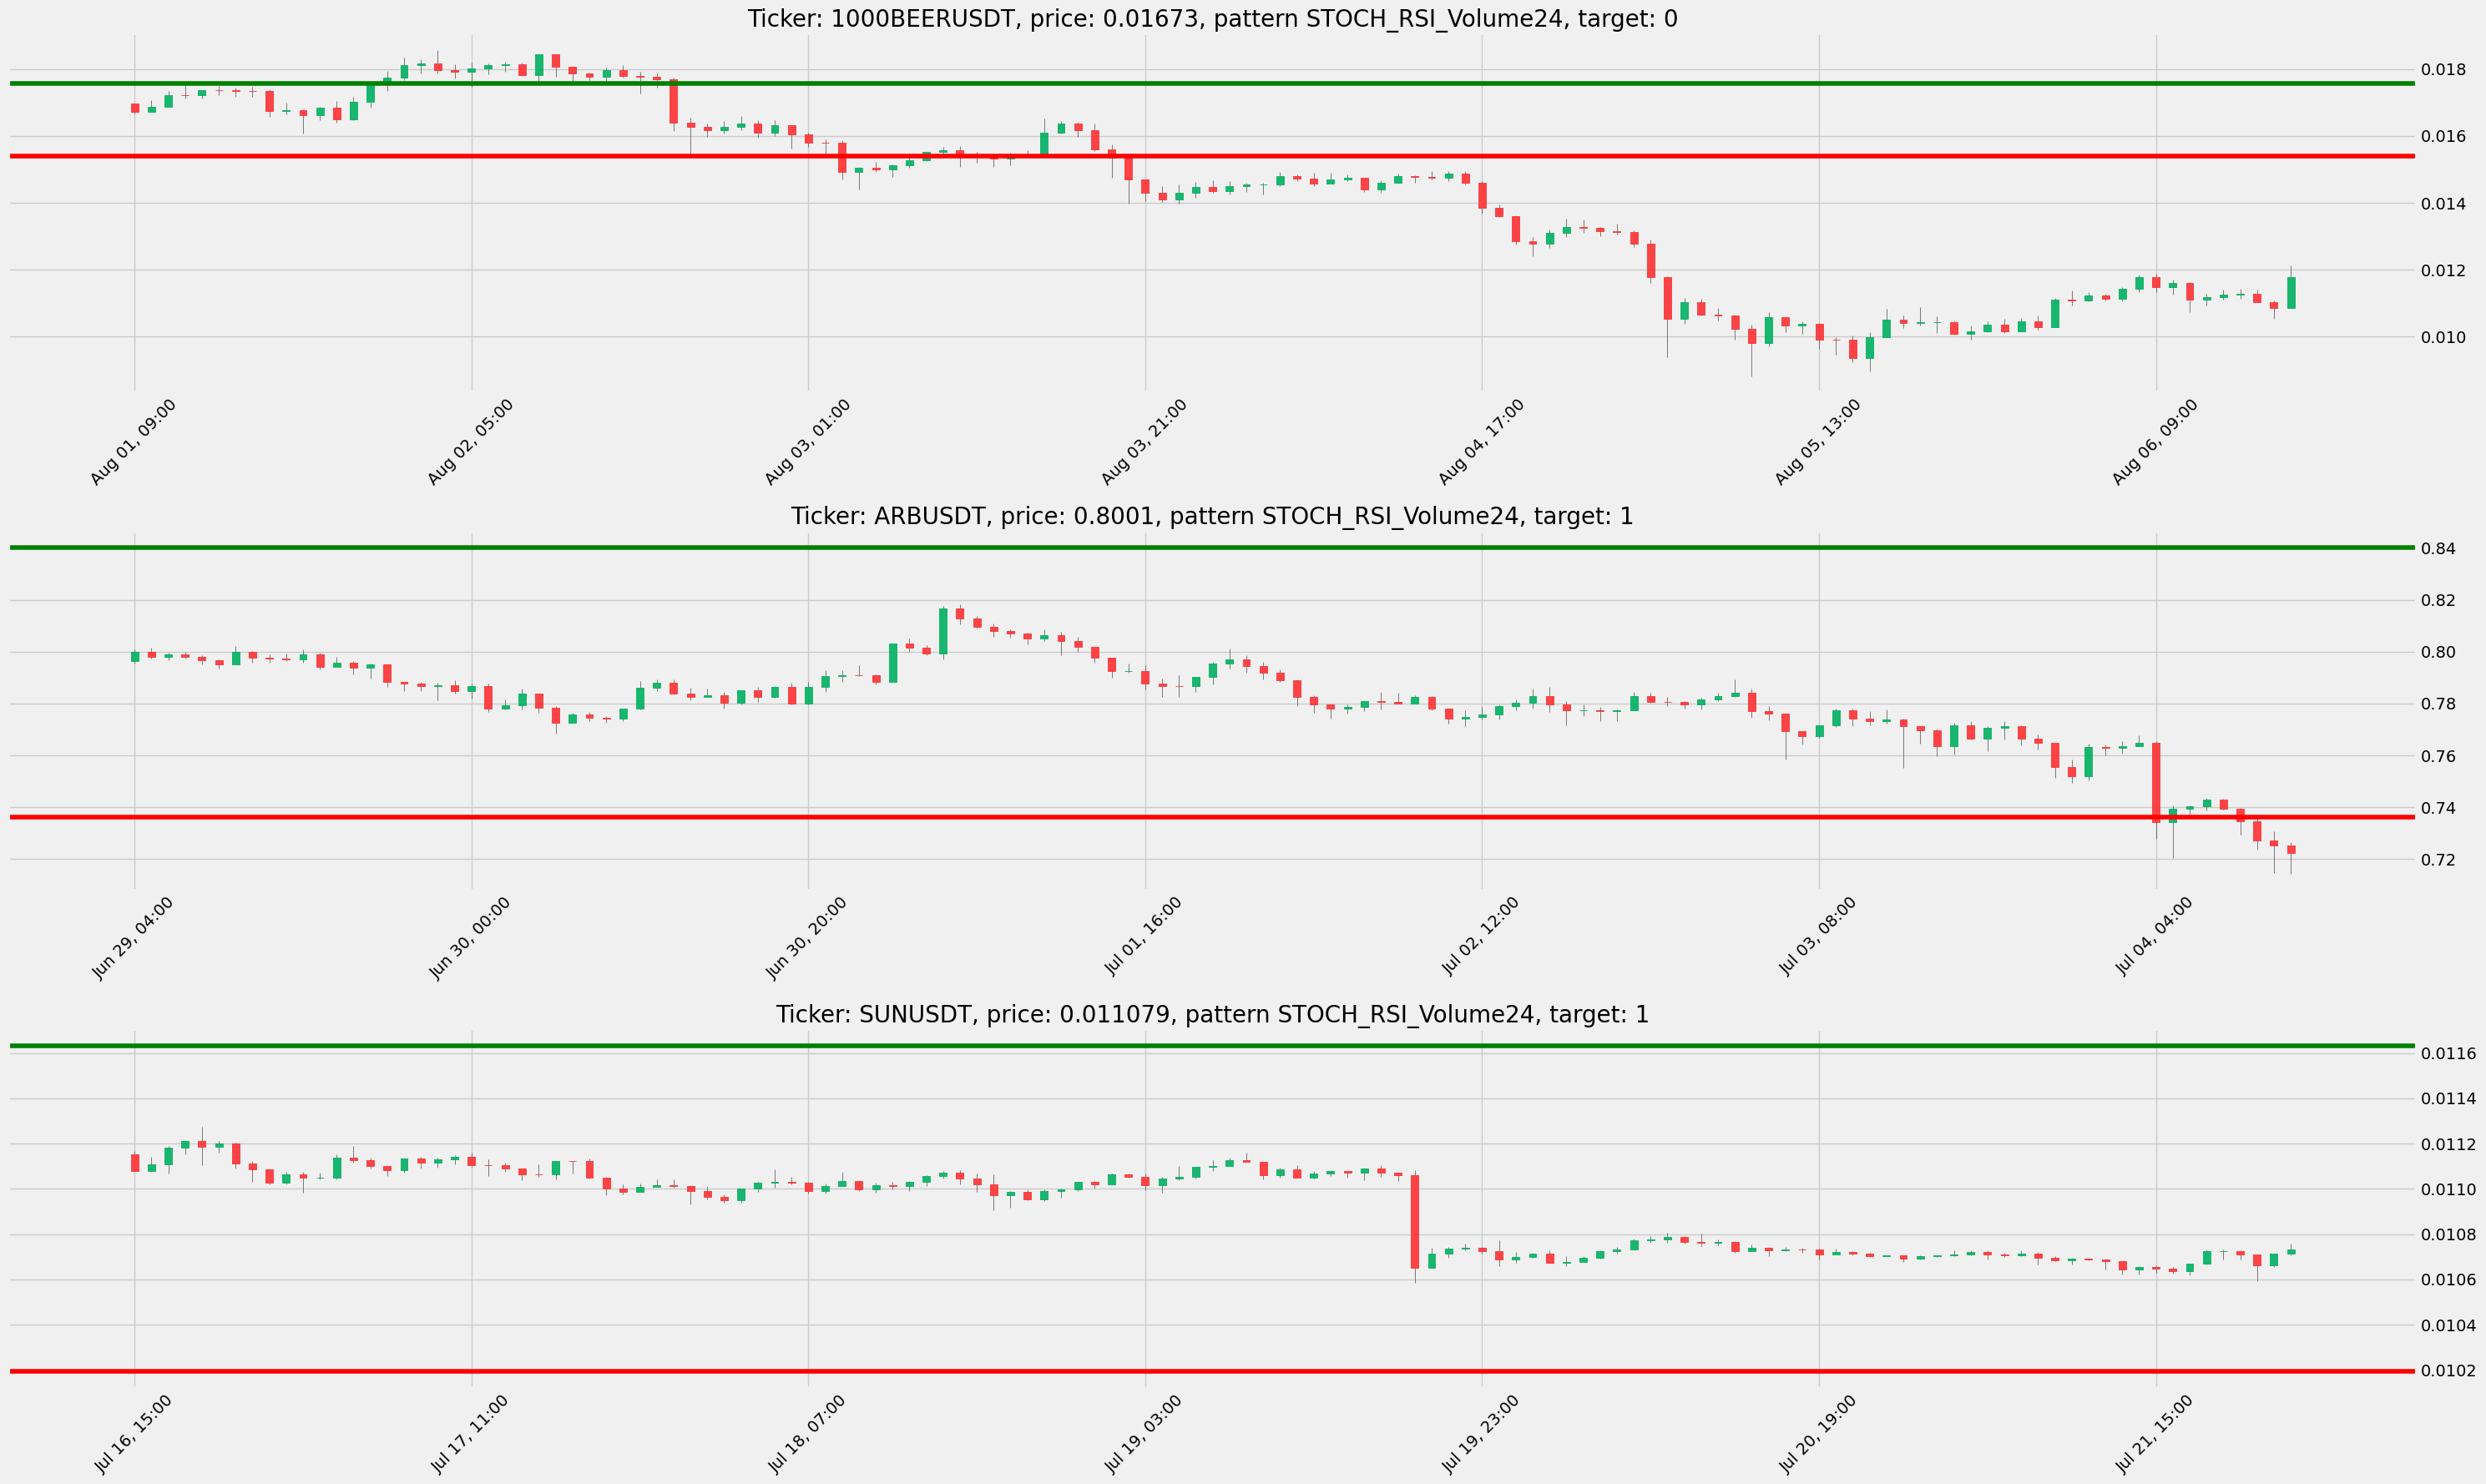

In [31]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]

        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_sl
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

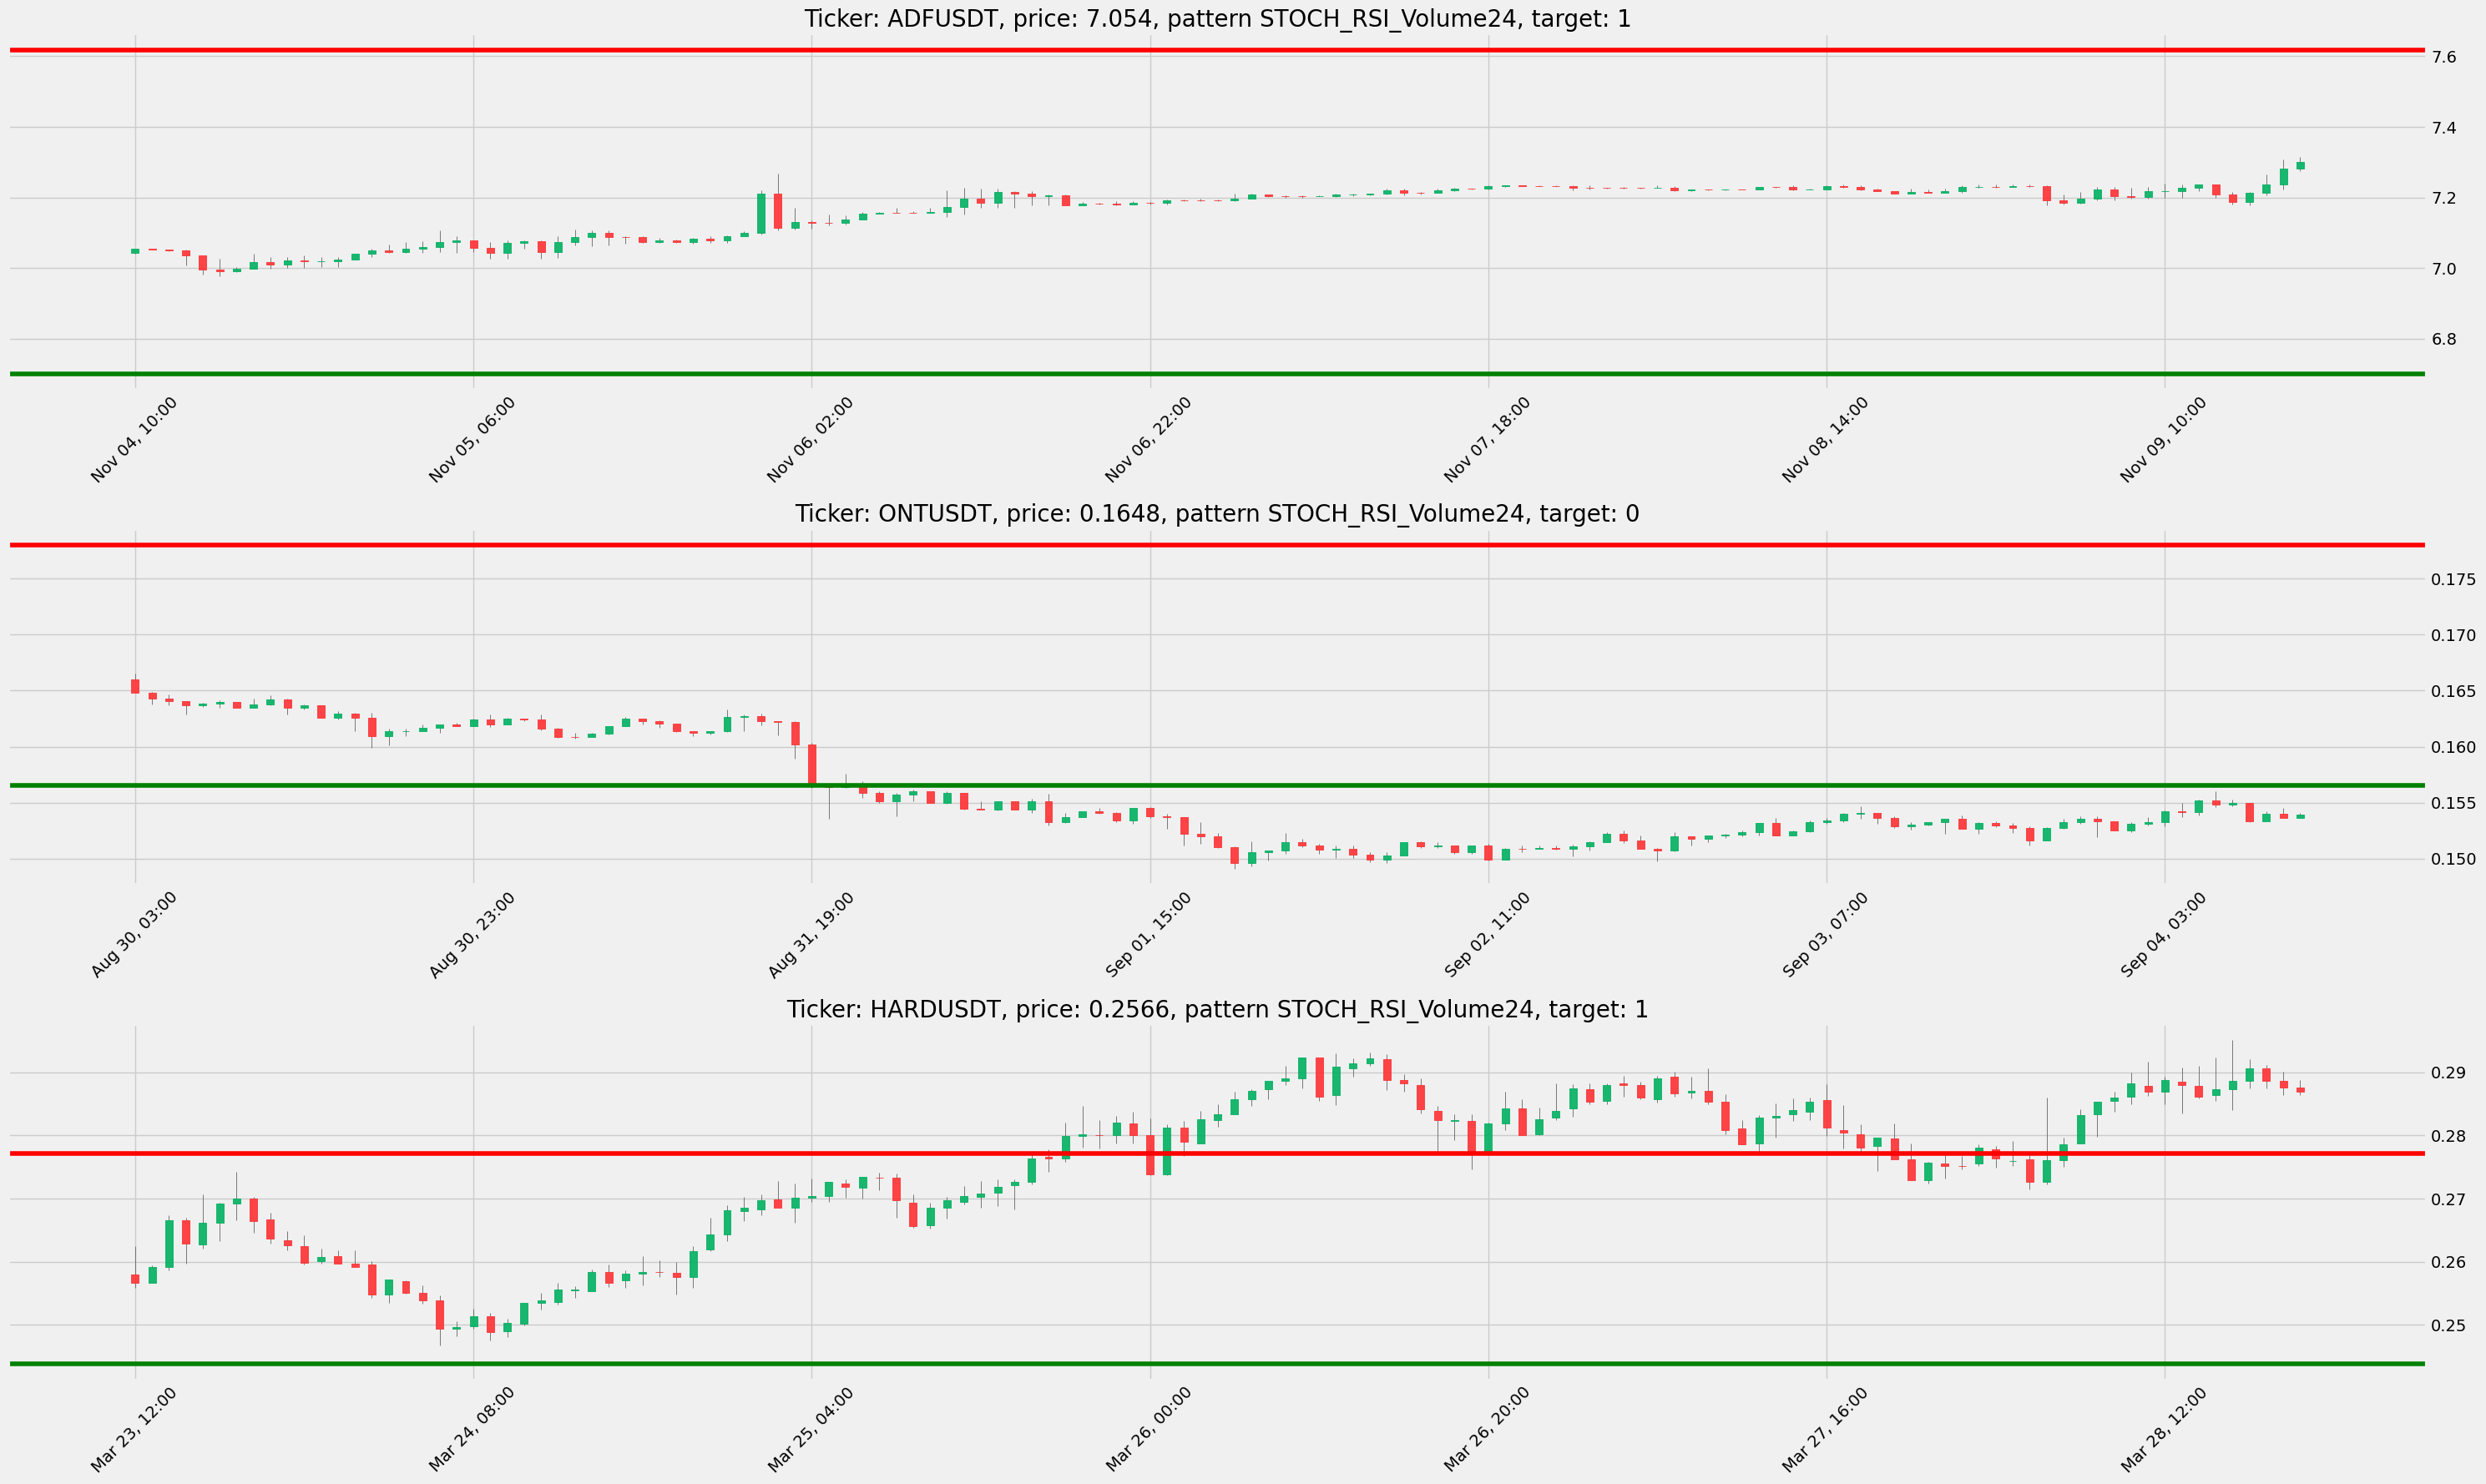

In [33]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]
        
        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_sl)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

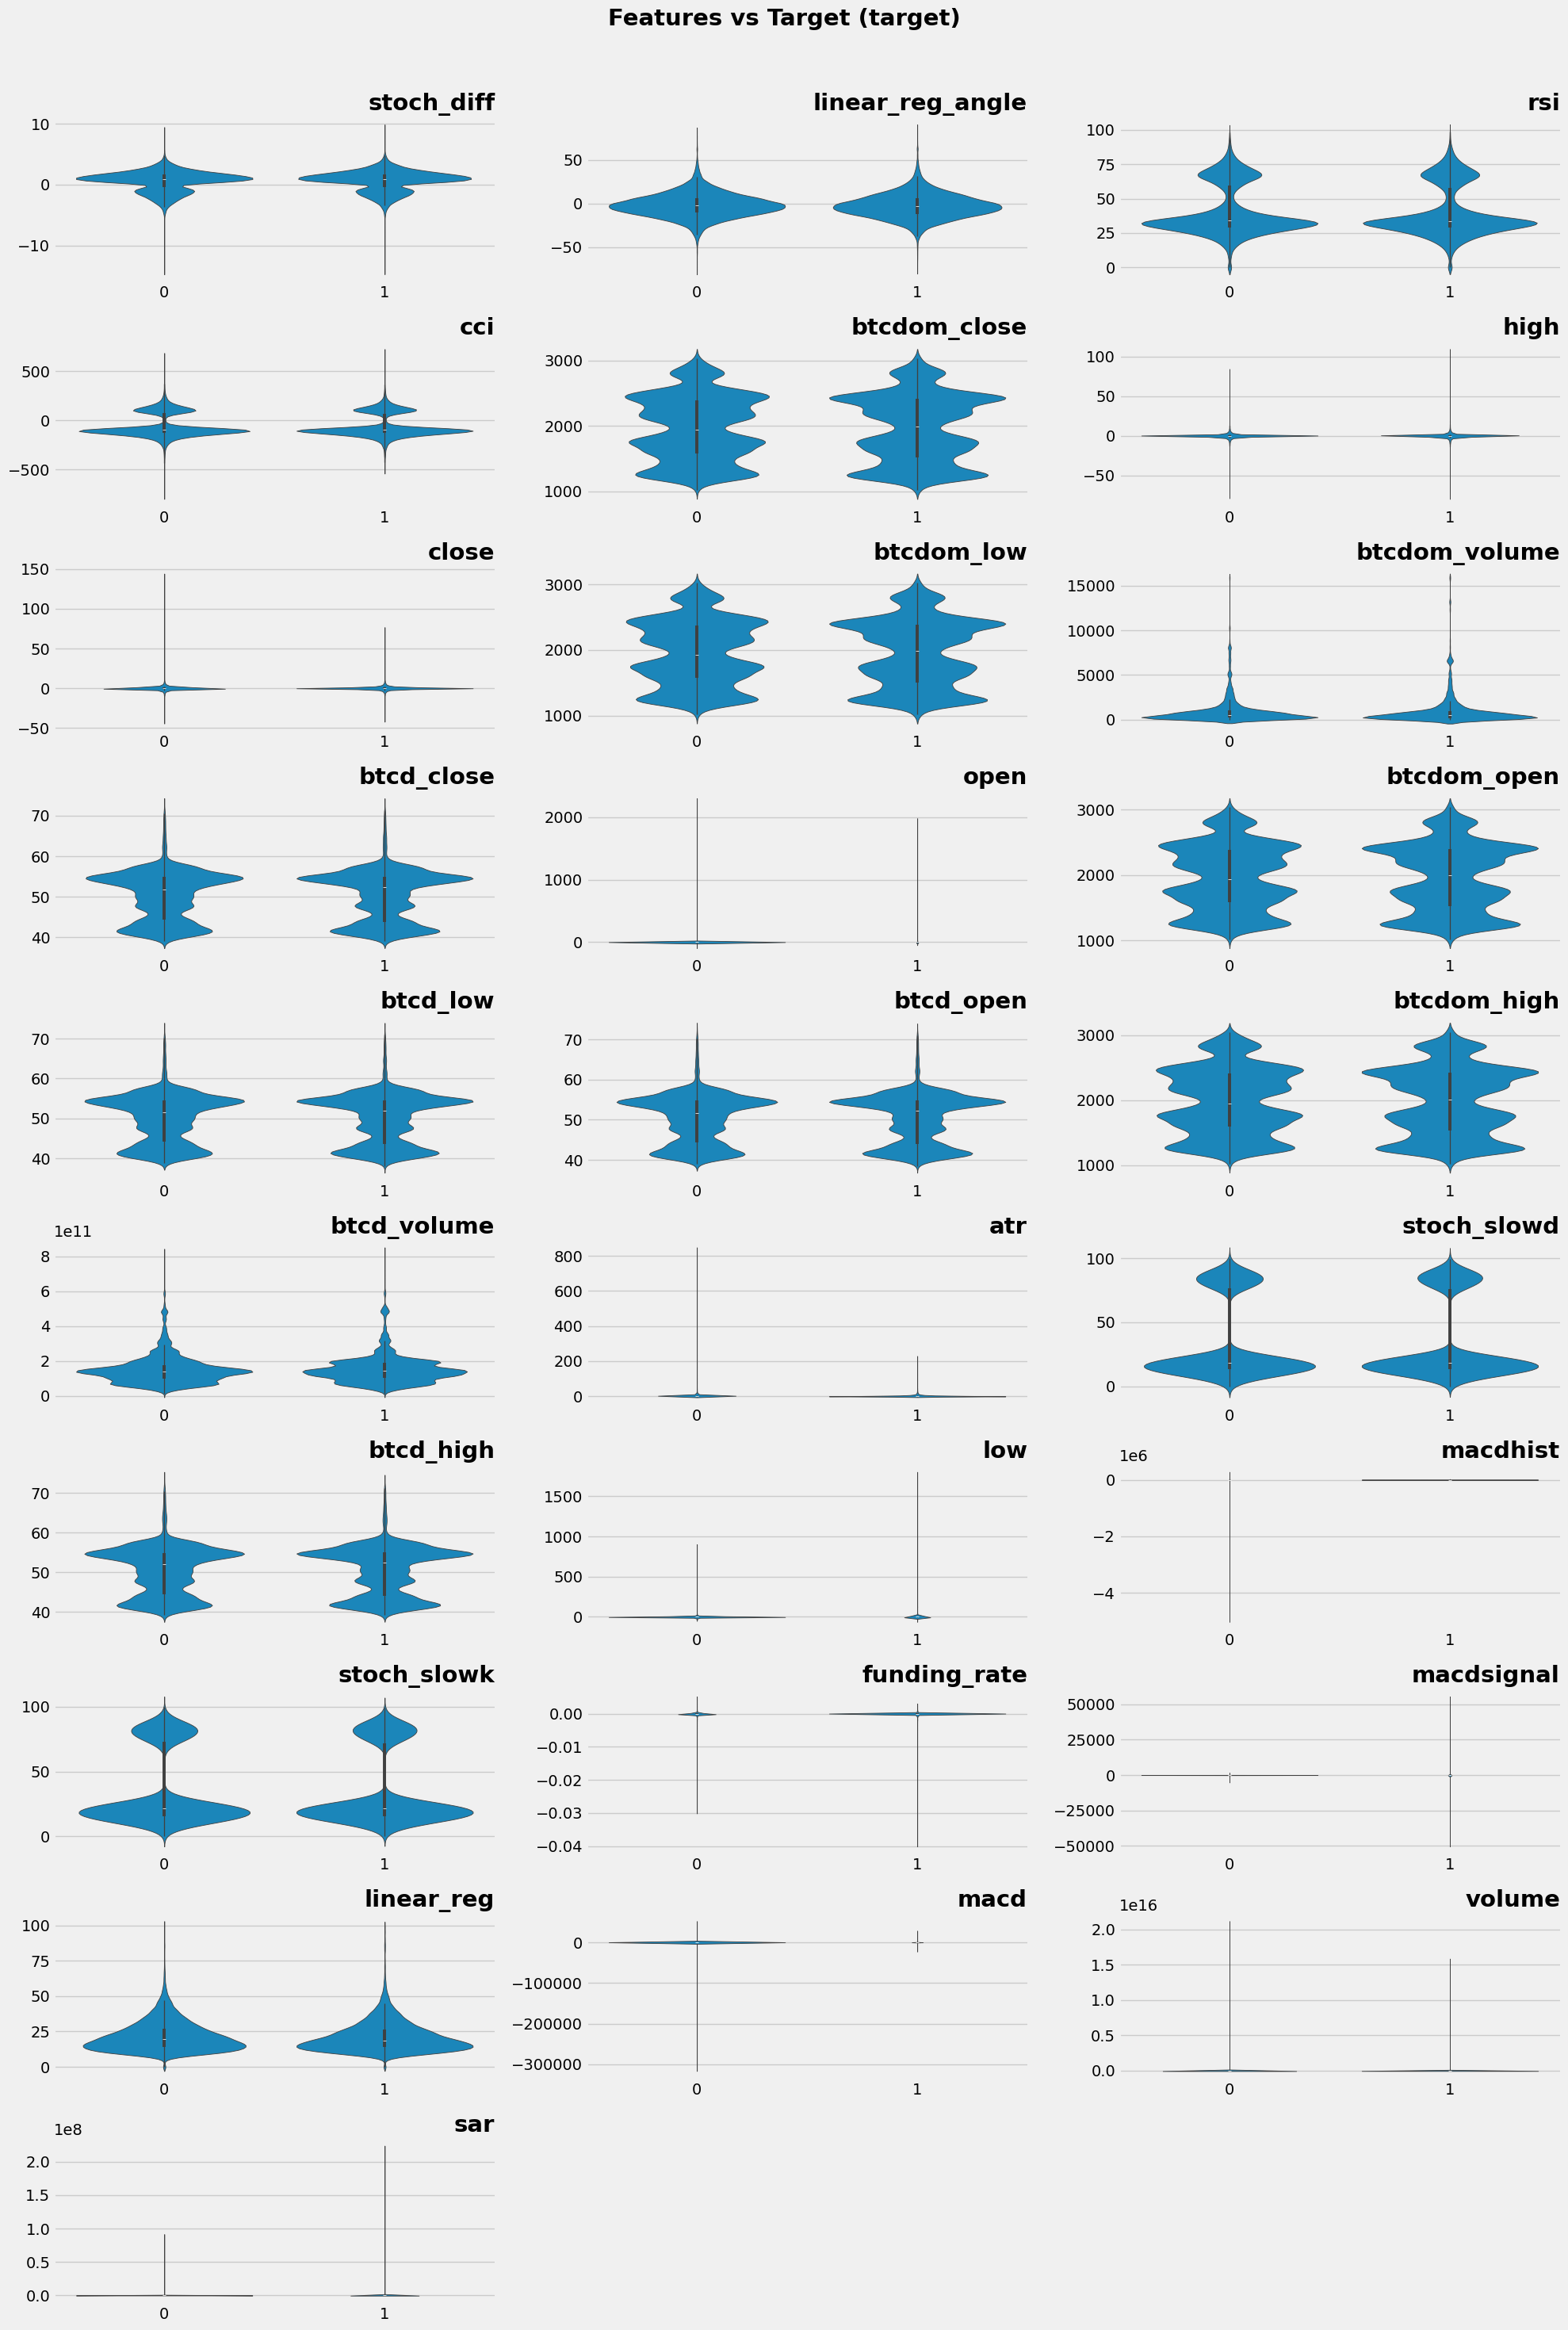

In [19]:
fi = pd.read_csv(f"model/feature_importance.csv")["Feature"].to_list()
cols = [c for c in fi if "prev" not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(""); ax.spines["top"].set_visible(False), 
        ax.set_xlabel(""); ax.spines["right"].set_visible(False)
        ax.set_title(f"{col}", loc="right", weight="bold", fontsize=21)

    
    fig.suptitle(f"Features vs Target ({target})\n\n\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target="target")

### Show the last signals

In [20]:
x = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
x["ttype"] = "buy"
y = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
y["ttype"] = "sell"
x = pd.concat([x, y]).sort_values("time").reset_index(drop=True)
x.loc[x["pattern"] == "STOCH_RSI_Volume24", ["time", "ticker", "ttype", "pattern"]].tail(50
                                                                                        )

,time,ticker,ttype,pattern
124657,2024-09-23 07:00:00,ZANOUSDT,buy,STOCH_RSI_Volume24
124658,2024-09-23 07:00:00,PRIMEUSDT,sell,STOCH_RSI_Volume24
124659,2024-09-23 07:00:00,CXTUSDT,sell,STOCH_RSI_Volume24
124660,2024-09-23 08:00:00,PUSHUSDT,sell,STOCH_RSI_Volume24
124661,2024-09-23 08:00:00,CLVUSDT,sell,STOCH_RSI_Volume24
124662,2024-09-23 08:00:00,PROPCUSDT,sell,STOCH_RSI_Volume24
124663,2024-09-23 09:00:00,AEROUSDT,sell,STOCH_RSI_Volume24
124664,2024-09-23 09:00:00,MTMSUSDT,sell,STOCH_RSI_Volume24
124665,2024-09-23 10:00:00,SPECUSDT,sell,STOCH_RSI_Volume24
124666,2024-09-23 10:00:00,DEGENUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [21]:
from shaphypetune import BoostBoruta
  
params = {
          "boosting_type": "dart",
          "n_estimators": 1000,
          "learning_rate": 0.02,
          "max_depth": 10,
          "subsample" : 0.7,
          "colsample_bytree": 0.85,
          "num_leaves": 24,
          "verbosity": -1,
          "importance_type": "gain",
          "max_bin": 255,
          "reg_alpha": 1e-6,
          "reg_lambda": 1e-7,
          "objective": "binary",
          "metric": "auc"
        }
features = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "max_price_deviation"]]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return "ppv_npv_acc", ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = "logloss"

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f"Fold: {fold}")
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type="shap_importances", train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric="logloss", 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({"importance": model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values("importance")
    boruta_df_ = boruta_df_.reset_index().rename({"index": "Feature"}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [22]:
palette = ["#302c36", "#037d97", "#E4591E", "#C09741",
           "#EC5B6D", "#90A6B1", "#6ca957", "#D8E3E2"]

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# load the list of Bybit tickers
with open(f"model/bybit_tickers.json", "r") as f:
    bybit_tickers = json.load(f)

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]
    
    for fold in range(CFG.n_repeats):
        print(f"Repeat {blu}#{fold+1}")

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric="logloss", 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f"Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}")

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=["Value","Feature"])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_["Value"] += f_i["Value"]
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({"importance": perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f"{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}")
    print(f"{'*' * 50}\n")
    
    if permut:
        perm_df_ = perm_df_.sort_values("importance", ascending=False)
        perm_df_ = perm_df_.reset_index().rename({"index": "Feature"}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values("Value", ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          "penalty": "l2",
          "max_iter": 10000,
          "C": 1
        }

    scaler = StandardScaler()
    X, y = df[features], df["target"]
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({"importance": selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({"index": "Feature"}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [24]:
if CFG.select_features:
    boruta_df_["rank"] = boruta_df_["importance"].rank()
    perm_df_["rank"] = perm_df_["importance"].rank(ascending=False)
    rfe_df_["rank"] = rfe_df_["importance"]
    feature_importances_["rank"] = feature_importances_["Value"].rank(ascending=False)

    fi = pd.concat([perm_df_[["Feature","rank"]], feature_importances_[["Feature","rank"]], rfe_df_[["Feature","rank"]],
                    boruta_df_[["Feature","rank"]]])
    fi = fi.groupby("Feature")["rank"].sum().sort_values().reset_index()
    fi.to_csv(f"model/feature_importance.csv", index=False)
else:
    fi = pd.read_csv(f"model/feature_importance.csv")

# Train

In [25]:
def load_params_from_optuna(row_num=0) -> dict:
    optuna_df = pd.read_csv("optuna/optuna_lgbm.csv")
    columns = [c for c in optuna_df.columns if c.startswith("params_")]
    row = optuna_df[columns].iloc[row_num]
    params = {key[7:]: value for key, value in row.to_dict().items()}
    return params

params = load_params_from_optuna()
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7719682931575004,
 'corr_thresh': 0.7857061570255112,
 'feature_num': 30,
 'high_bound': 0.5079317949929507,
 'is_unbalance': False,
 'learning_rate': 0.0566651443137569,
 'low_bound': 0.0522796255920315,
 'max_bin': 143,
 'max_depth': 7,
 'max_train_size': 0.5096138255038595,
 'n_estimators': 2076,
 'num_leaves': 413,
 'reg_alpha': 1.1550193688154498,
 'reg_lambda': 0.0006356169374063,
 'sample_weight': 'linear',
 'subsample': 0.6112788963304607}

### Load selected features

In [26]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations["level_0"] != correlations["level_1"]] 
    correlations.columns = ["feature_1", "feature_2", "corr"]

    correlations = pd.merge(left=correlations, right=fi, how="left", left_on="feature_1", right_on="Feature")
    correlations = correlations.drop(columns="Feature")
    correlations = correlations.sort_values(["corr", "rank"], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations["corr"] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row["feature_1"]
        feature_2 = row["feature_2"]

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    """ Get features, sort them by their time appearance and return for using in train and inference"""
    # exclude some features 
    fi = fi["Feature"]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == "volume_24":
            feature_dict[0].append(f)
            continue
        period = f.split("_")
        if period[-1].isdigit() and period[-2] == "prev":
            feature_dict[int(period[-1])].append("_".join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f"_prev_{item[0]}" for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ["weekday", "hour"]
    
    # remove highly correlated features from the feature dict
    feature_dict["features"] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f"{f}_prev_{item[0]}"
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

feature_num = params["feature_num"]
corr_thresh = params["corr_thresh"]

del params["feature_num"]
del params["corr_thresh"]

# feature_num = 58
# corr_thresh = 0.5324216723399987

train_df["hour"] = train_df["time"].dt.hour
train_df["weekday"] = train_df["time"].dt.weekday
fi = pd.read_csv("model/feature_importance.csv")
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['stoch_diff',
 'linear_reg_angle',
 'rsi',
 'btcdom_close',
 'btcdom_volume_prev_4',
 'btcdom_volume_prev_20',
 'btcd_volume_prev_24',
 'btcdom_volume_prev_28',
 'btcdom_volume_prev_40',
 'btcdom_volume_prev_56',
 'btcd_volume_prev_96',
 'btcdom_volume_prev_108',
 'btcdom_volume_prev_116',
 'btcdom_volume_prev_124',
 'btcdom_volume_prev_128',
 'btcdom_volume_prev_140',
 'btcdom_volume_prev_148',
 'btcdom_volume_prev_152',
 'btcdom_volume_prev_172',
 'btcd_volume_prev_192',
 'btcdom_volume_prev_192',
 'btcdom_volume_prev_196',
 'btcdom_volume_prev_216',
 'btcdom_volume_prev_220',
 'low_prev_224',
 'btcdom_volume_prev_232',
 'btcd_volume_prev_240',
 'weekday',
 'hour']

29

### Functions for train

In [27]:
from __future__ import annotations
from scipy.stats import ttest_rel


def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, sample_weight: Union[list, None],
                n_folds: int, low_bound: float, high_bound: float, train_test: str, 
                max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == "fold")
        - list of profitable objects by folds (if train_test == "fold")
    """
    X, time = df[features], df["time"]
    y = df["target"]
    val_idxs = []
    conf_scores =[]
    conf_object_nums = []
    max_train_size = int(len(df) * max_train_size)
    
    if train_test == "fold":
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f"Fold #{fold + 1}")
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], "time"])
                display(df.loc[val_idx[-1], "time"])

                plt.plot(train_df.index[fit_idx], [fold + 1] * len(fit_idx), label=f'Train {fold + 1}', color='blue')
                plt.plot(train_df.index[val_idx], [fold + 1] * len(val_idx), label=f'Test {fold + 1}', color='red')
                
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            if sample_weight is not None:
                sample_weight = df.loc[fit_idx, "weight"]
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, sample_weight=sample_weight, 
                          eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric="logloss", callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:, 1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f"Logloss: {val_score}, Confident objects score: {conf_score}\n"
                      f"Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n"
                      f"Number of profitable objects: {round((2 * conf_score -  1) * conf_obj_num)}")
        
        if verbose:
            plt.ylim(0.5, n_folds + 0.5)
            plt.xlabel('Index')
            plt.ylabel('Fold')
            plt.title('Train/Test Distribution for Time-Series Split')
            plt.legend(['Train', 'Test'], loc='lower right')
            plt.show()
        
        return model_lgb, conf_scores, conf_object_nums, oof, val_idxs
    elif train_test == "inference":
        print("Train on full data")
        X, y = df.iloc[-max_train_size:][features], df.iloc[-max_train_size:]["target"]
        if sample_weight is not None:
                sample_weight = df.iloc[-max_train_size:]["weight"]
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, sample_weight=sample_weight, eval_set=[(X, y)], 
                      eval_metric="logloss", callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Functions for backtest

In [28]:
TP = 0.08 # real take profit that we set in our trade
SL = 0.05
risk = 0.003 # what part of deposit we use in one trade
leverage = 4
price_change = SL * leverage
min_free_balance = 0.2

open_comission = 0.00036 # Bybit comission for trade opening
close_comission = 0.001 # Bybit comission for trade closing

# consider trade slippage, let it be ~ 0.2%
slippage = 0.002
TP -= slippage
SL += slippage

def calculate_profit(target, quantity, first_price, last_price):
    """Calculate profit change according to trade success and comissions"""
    if target == 1:
        if last_price > 0: 
            # if price doesn't reach TP or SL - calculate profit
            # from price of entering and exiting of trade
            trade_profit = quantity * (1 + (last_price - first_price) / first_price * leverage)
        else:
            # TP reached
            trade_profit = quantity * (1 + TP * leverage)
    else:
        # SL reached
        trade_profit = quantity * (1 - SL * leverage)
        
    # subtract Bybit close comission 
    trade_profit *=  (1 - close_comission)
    # subtract possible slippage

    profit = trade_profit - quantity
    return profit, trade_profit


def backtest(df: pd.DataFrame, oof: pd.Series, val_idxs: pd.Series, high_bound: float, show_progress: bool = False) -> float:
    """Function for model backtest"""
    # select only trades in which model is confident
    backtest_df = df.loc[val_idxs, ["target", "max_price_deviation", "time", "close_time", "first_price", "last_price"]]
    backtest_df["pred"] = oof
    backtest_df = backtest_df[backtest_df["pred"] >= high_bound].reset_index(drop=True)
    backtest_df["balance"] = 1
    backtest_df["free_balance"] = 1
    backtest_df["profit"] = 0
    backtest_df["trade_profit"] = 0
    backtest_df["quantity"] = 0
    backtest_df["profit_count"] = 0

    # set for tracking of not closed trades
    not_closed_trade_idxs = set()
    
    if show_progress:
        generator = tqdm(backtest_df.iterrows(), total=len(backtest_df))
    else:
        generator = backtest_df.iterrows()

    # move through the dataset row-by-row
    for i, row in generator:
        j = i - 1
        # take balance from previous signal 
        # or if signal is first - set balance to 1
        if j >= 0:
            balance = backtest_df.loc[j, "balance"]
            free_balance = backtest_df.loc[j, "free_balance"]
        else:
            balance = free_balance = 1
        
        signal_time = row["time"]
        target = row["target"]
        first_price = row["first_price"]
        last_price = row["last_price"]
        
        closed_trade_idxs = []
        
        # update balance with previous signals info
        for j in not_closed_trade_idxs:
            prev_signal_close_time = backtest_df.loc[j, "close_time"]
            # if previous signal was closed - add its profit to the current balance 
            if signal_time >= prev_signal_close_time:
                free_balance += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "trade_profit"] += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "profit_count"] += 1
                closed_trade_idxs.append(j)

        # remove closed trades from set of not closed trades
        for j in closed_trade_idxs:
            not_closed_trade_idxs.remove(j)

        # perform trading operation only if have enough of free balance
        if free_balance >= min_free_balance * balance:
            # calculate quantity to use in trade
            quantity = free_balance * risk / price_change
            # subtact quantity + open comission from balance
            balance -= quantity * open_comission
            free_balance -= (quantity * (1 + open_comission))
            # get profit from the current trade
            profit, trade_profit = calculate_profit(target, quantity, first_price, last_price)
        else:
            profit, trade_profit = 0, 0

        # write balance and profit to the dataset
        backtest_df.loc[i, "quantity"] = quantity
        backtest_df.loc[i, "balance"] = balance + profit
        backtest_df.loc[i, "free_balance"] = free_balance
        backtest_df.loc[i, "profit"] = profit
        backtest_df.loc[i, "trade_profit"] = trade_profit

        not_closed_trade_idxs.add(i)

    if len(backtest_df) > 0:
        result = round(backtest_df['balance'].iloc[-1] * 100, 2)
    else:
        result = 0
    return result, backtest_df

### Functions for optimization

In [29]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     "device": "gpu",
#                     "gpu_platform_id": 0,
#                     "gpu_device_id": 0,
        "objective": "binary",
        "metric": "average_precison",
        "boosting_type": trial.suggest_categorical("boosting_type", ["dart", "goss", "gbdt"]), 
        # Hyperparamters (in order of importance decreasing)
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),  # max number of trees in model
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 3e-1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        "max_depth": trial.suggest_int("max_depth", 4, 10), # tree max depth 
         # decrease to deal with overfit
        "num_leaves": trial.suggest_int("num_leaves", 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        "max_bin": trial.suggest_int("max_bin", 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        "subsample_freq": 1, # Perform bagging at every k iteration, alias: bagging_freq

        # "subsample_for_bin": 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # "cat_smooth": trial.suggest_float("cat_smooth", 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),                                            
        "verbose": -1,
        "importance_type": "gain",
        "high_bound": trial.suggest_float("high_bound", 0.5, 0.65),
        "low_bound": trial.suggest_float("low_bound", 0.0, 0.1),
        "feature_num": trial.suggest_int("feature_num", 30, 600),
        "corr_thresh": trial.suggest_float("corr_thresh", 0.5, 0.99),
        "max_train_size": trial.suggest_float("max_train_size", 0.5, 1),
        "sample_weight": trial.suggest_categorical("sample_weight", [None, "cos", "linear"])
    }
    
    if params["boosting_type"] != "goss":
        params["subsample"] = trial.suggest_float("subsample", 0.3, 0.9)

    if params["is_unbalance"] == "True":
        params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None]), 

    high_bound = params["high_bound"]
    del params["high_bound"]

    low_bound = params["low_bound"]
    del params["low_bound"]

    corr_thresh = params["corr_thresh"]
    del params["corr_thresh"]

    # set max train size for TSS fold
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

    # add object weights
    sample_weight = params["sample_weight"]
    del params["sample_weight"]
    
    if sample_weight:
        train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
        if sample_weight == "cos":
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
            train_df["weight"] = np.cos(train_df["weight"])
        else:
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min())
        sample_weight = True
    
    fi = pd.read_csv(f"model/feature_importance.csv")
    feature_num = params["feature_num"]
    del params["feature_num"]
    
    train_df["weekday"] = train_df["time"].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    # train model, get results
    _, conf_scores, conf_object_nums,oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight,
                                                                 n_folds=10, low_bound=low_bound, high_bound=high_bound, 
                                                                 train_test="fold", max_train_size=max_train_size, verbose=False)
    
    # calculate total number of confident objects and total precison for the confident objects
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, _ = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    # result = oof_conf_obj_num * (oof_conf_score - CFG.min_precision) * 100
    result, _ = backtest(train_df, oof, val_idxs, high_bound)
    result *= (oof_conf_score - CFG.min_precision)
    
    # prepare result list for t-test
    results = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv("optuna/optuna_lgbm_info.csv")
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("value == value.max()")[["value", "values"]].values[0]
        best_scores = best_scores[1:-1].split(", ")
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(best_scores, results).pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                # increase result but discount the difference betweeen current result
                # and previous best result on (1 - p_value) 
                result = best_result + (result - best_result) * (1 - p_value)
    
    tmp = pd.DataFrame({
                        "value": [result], 
                        "total_conf_score": [oof_conf_score],
                        "values": [(results)], 
                        "profit_objects": [profit_objects],
                        "total_conf_obj_num": [oof_conf_obj_num] 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    return result

### Train / optimize process

In [32]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7719682931575004,
 'is_unbalance': False,
 'learning_rate': 0.0566651443137569,
 'low_bound': 0.0522796255920315,
 'max_bin': 143,
 'max_depth': 7,
 'n_estimators': 2076,
 'num_leaves': 413,
 'reg_alpha': 1.1550193688154498,
 'reg_lambda': 0.0006356169374063,
 'subsample': 0.6112788963304607}

Training with 29 features
Fold #1


1    0.516262
0    0.483738
Name: target, dtype: float64

Timestamp('2023-03-09 03:00:00')

Timestamp('2023-06-08 03:00:00')

[100]	training's binary_logloss: 0.499482	valid_1's binary_logloss: 0.697802
[200]	training's binary_logloss: 0.434106	valid_1's binary_logloss: 0.702674
[300]	training's binary_logloss: 0.387048	valid_1's binary_logloss: 0.715853
[400]	training's binary_logloss: 0.350041	valid_1's binary_logloss: 0.725885
[500]	training's binary_logloss: 0.319964	valid_1's binary_logloss: 0.731049
[600]	training's binary_logloss: 0.295617	valid_1's binary_logloss: 0.741018
[700]	training's binary_logloss: 0.273695	valid_1's binary_logloss: 0.749256
[800]	training's binary_logloss: 0.254596	valid_1's binary_logloss: 0.760197
[900]	training's binary_logloss: 0.238396	valid_1's binary_logloss: 0.766241
[1000]	training's binary_logloss: 0.224726	valid_1's binary_logloss: 0.770212
[1100]	training's binary_logloss: 0.21291	valid_1's binary_logloss: 0.773099
[1200]	training's binary_logloss: 0.202334	valid_1's binary_logloss: 0.773206
[1300]	training's binary_logloss: 0.192781	valid_1's binary_logloss: 0.776

0    0.511001
1    0.488999
Name: target, dtype: float64

Timestamp('2023-06-13 03:00:00')

Timestamp('2023-10-09 20:00:00')

[100]	training's binary_logloss: 0.502502	valid_1's binary_logloss: 0.713607
[200]	training's binary_logloss: 0.440366	valid_1's binary_logloss: 0.737426
[300]	training's binary_logloss: 0.39568	valid_1's binary_logloss: 0.737537
[400]	training's binary_logloss: 0.361232	valid_1's binary_logloss: 0.744212
[500]	training's binary_logloss: 0.333751	valid_1's binary_logloss: 0.748646
[600]	training's binary_logloss: 0.309953	valid_1's binary_logloss: 0.757768
[700]	training's binary_logloss: 0.288306	valid_1's binary_logloss: 0.760921
[800]	training's binary_logloss: 0.270149	valid_1's binary_logloss: 0.761799
[900]	training's binary_logloss: 0.254757	valid_1's binary_logloss: 0.766295
[1000]	training's binary_logloss: 0.242078	valid_1's binary_logloss: 0.770903
[1100]	training's binary_logloss: 0.22963	valid_1's binary_logloss: 0.777448
[1200]	training's binary_logloss: 0.218332	valid_1's binary_logloss: 0.775486
[1300]	training's binary_logloss: 0.208665	valid_1's binary_logloss: 0.7787

1    0.501274
0    0.498726
Name: target, dtype: float64

Timestamp('2023-10-13 21:00:00')

Timestamp('2024-01-22 23:00:00')

[100]	training's binary_logloss: 0.511185	valid_1's binary_logloss: 0.70169
[200]	training's binary_logloss: 0.454954	valid_1's binary_logloss: 0.709841
[300]	training's binary_logloss: 0.412356	valid_1's binary_logloss: 0.714337
[400]	training's binary_logloss: 0.379353	valid_1's binary_logloss: 0.719232
[500]	training's binary_logloss: 0.351631	valid_1's binary_logloss: 0.724916
[600]	training's binary_logloss: 0.32833	valid_1's binary_logloss: 0.732411
[700]	training's binary_logloss: 0.308284	valid_1's binary_logloss: 0.728761
[800]	training's binary_logloss: 0.290863	valid_1's binary_logloss: 0.729874
[900]	training's binary_logloss: 0.275743	valid_1's binary_logloss: 0.733937
[1000]	training's binary_logloss: 0.262307	valid_1's binary_logloss: 0.733834
[1100]	training's binary_logloss: 0.249679	valid_1's binary_logloss: 0.735775
[1200]	training's binary_logloss: 0.238392	valid_1's binary_logloss: 0.740438
[1300]	training's binary_logloss: 0.228501	valid_1's binary_logloss: 0.7446

1    0.586488
0    0.413512
Name: target, dtype: float64

Timestamp('2024-01-27 08:00:00')

Timestamp('2024-04-01 15:00:00')

[100]	training's binary_logloss: 0.487326	valid_1's binary_logloss: 0.657533
[200]	training's binary_logloss: 0.43647	valid_1's binary_logloss: 0.657075
[300]	training's binary_logloss: 0.399931	valid_1's binary_logloss: 0.661563
[400]	training's binary_logloss: 0.371337	valid_1's binary_logloss: 0.667192
[500]	training's binary_logloss: 0.347498	valid_1's binary_logloss: 0.670706
[600]	training's binary_logloss: 0.326996	valid_1's binary_logloss: 0.678944
[700]	training's binary_logloss: 0.309676	valid_1's binary_logloss: 0.680694
[800]	training's binary_logloss: 0.292851	valid_1's binary_logloss: 0.68056
[900]	training's binary_logloss: 0.278537	valid_1's binary_logloss: 0.685869
[1000]	training's binary_logloss: 0.266587	valid_1's binary_logloss: 0.687538
[1100]	training's binary_logloss: 0.255873	valid_1's binary_logloss: 0.68986
[1200]	training's binary_logloss: 0.246237	valid_1's binary_logloss: 0.691385
[1300]	training's binary_logloss: 0.2376	valid_1's binary_logloss: 0.694909


1    0.542056
0    0.457944
Name: target, dtype: float64

Timestamp('2024-04-05 16:00:00')

Timestamp('2024-05-08 18:00:00')

[100]	training's binary_logloss: 0.494663	valid_1's binary_logloss: 0.626781
[200]	training's binary_logloss: 0.444444	valid_1's binary_logloss: 0.623288
[300]	training's binary_logloss: 0.410243	valid_1's binary_logloss: 0.613369
[400]	training's binary_logloss: 0.383941	valid_1's binary_logloss: 0.614543
[500]	training's binary_logloss: 0.362091	valid_1's binary_logloss: 0.606919
[600]	training's binary_logloss: 0.343674	valid_1's binary_logloss: 0.604024
[700]	training's binary_logloss: 0.327391	valid_1's binary_logloss: 0.607731
[800]	training's binary_logloss: 0.312805	valid_1's binary_logloss: 0.607814
[900]	training's binary_logloss: 0.299551	valid_1's binary_logloss: 0.610351
[1000]	training's binary_logloss: 0.288937	valid_1's binary_logloss: 0.605949
[1100]	training's binary_logloss: 0.27913	valid_1's binary_logloss: 0.606024
[1200]	training's binary_logloss: 0.26989	valid_1's binary_logloss: 0.606634
[1300]	training's binary_logloss: 0.261586	valid_1's binary_logloss: 0.6050

1    0.529231
0    0.470769
Name: target, dtype: float64

Timestamp('2024-05-13 01:00:00')

Timestamp('2024-06-20 14:00:00')

[100]	training's binary_logloss: 0.504614	valid_1's binary_logloss: 0.635833
[200]	training's binary_logloss: 0.457245	valid_1's binary_logloss: 0.626803
[300]	training's binary_logloss: 0.424126	valid_1's binary_logloss: 0.6245
[400]	training's binary_logloss: 0.398713	valid_1's binary_logloss: 0.627549
[500]	training's binary_logloss: 0.378242	valid_1's binary_logloss: 0.630041
[600]	training's binary_logloss: 0.360474	valid_1's binary_logloss: 0.628983
[700]	training's binary_logloss: 0.345613	valid_1's binary_logloss: 0.633593
[800]	training's binary_logloss: 0.331913	valid_1's binary_logloss: 0.635099
[900]	training's binary_logloss: 0.320184	valid_1's binary_logloss: 0.636194
[1000]	training's binary_logloss: 0.309755	valid_1's binary_logloss: 0.63717
[1100]	training's binary_logloss: 0.300279	valid_1's binary_logloss: 0.636717
[1200]	training's binary_logloss: 0.291664	valid_1's binary_logloss: 0.636908
[1300]	training's binary_logloss: 0.283858	valid_1's binary_logloss: 0.64071

1    0.725902
0    0.274098
Name: target, dtype: float64

Timestamp('2024-06-24 15:00:00')

Timestamp('2024-08-04 02:00:00')

[100]	training's binary_logloss: 0.511184	valid_1's binary_logloss: 0.703948
[200]	training's binary_logloss: 0.470553	valid_1's binary_logloss: 0.702336
[300]	training's binary_logloss: 0.442384	valid_1's binary_logloss: 0.700746
[400]	training's binary_logloss: 0.420117	valid_1's binary_logloss: 0.706824
[500]	training's binary_logloss: 0.401956	valid_1's binary_logloss: 0.705528
[600]	training's binary_logloss: 0.386425	valid_1's binary_logloss: 0.707569
[700]	training's binary_logloss: 0.373329	valid_1's binary_logloss: 0.703234
[800]	training's binary_logloss: 0.360931	valid_1's binary_logloss: 0.704192
[900]	training's binary_logloss: 0.350571	valid_1's binary_logloss: 0.70075
[1000]	training's binary_logloss: 0.341583	valid_1's binary_logloss: 0.710011
[1100]	training's binary_logloss: 0.333158	valid_1's binary_logloss: 0.702551
[1200]	training's binary_logloss: 0.325256	valid_1's binary_logloss: 0.702121
[1300]	training's binary_logloss: 0.318053	valid_1's binary_logloss: 0.703

1    0.554444
0    0.445556
Name: target, dtype: float64

Timestamp('2024-08-08 03:00:00')

Timestamp('2024-09-23 01:00:00')

[100]	training's binary_logloss: 0.53129	valid_1's binary_logloss: 0.746338
[200]	training's binary_logloss: 0.495235	valid_1's binary_logloss: 0.751466
[300]	training's binary_logloss: 0.469899	valid_1's binary_logloss: 0.748727
[400]	training's binary_logloss: 0.450534	valid_1's binary_logloss: 0.746086
[500]	training's binary_logloss: 0.43459	valid_1's binary_logloss: 0.749924
[600]	training's binary_logloss: 0.420596	valid_1's binary_logloss: 0.745421
[700]	training's binary_logloss: 0.408001	valid_1's binary_logloss: 0.74748
[800]	training's binary_logloss: 0.397182	valid_1's binary_logloss: 0.74887
[900]	training's binary_logloss: 0.387926	valid_1's binary_logloss: 0.748042
[1000]	training's binary_logloss: 0.37981	valid_1's binary_logloss: 0.750623
[1100]	training's binary_logloss: 0.372338	valid_1's binary_logloss: 0.749094
[1200]	training's binary_logloss: 0.365774	valid_1's binary_logloss: 0.75181
[1300]	training's binary_logloss: 0.359448	valid_1's binary_logloss: 0.751293
[

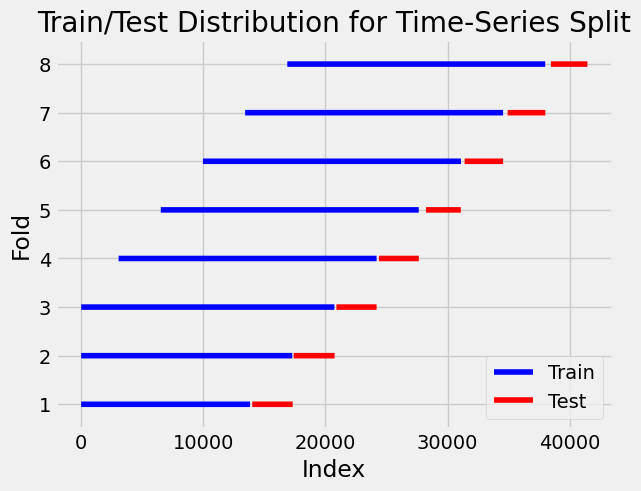

Total confident object score: 0.5936139332365747
Total number of confident objects 7579
Total number of profitable objects: 1419
Results: [5750.000000000001, 699.9999999999991, 1499.9999999999968, 11049.999999999996, 16499.999999999996, 12400.0, 19549.999999999996, 3500.0000000000014]


In [35]:
# params = {
#     "boosting_type": "gbdt",
#     "n_estimators": 964,
#     "learning_rate": 0.003568,
#     "reg_alpha": 0.002782,
#     "reg_lambda": 0.00005,
#     "max_depth": 4,
#     "num_leaves": 16,
#     "colsample_bytree": 0.431844,
#     "max_bin": 135,
#     "is_unbalance": True,
#     "class_weight": "balanced",
#     "subsample": 0.673918,
#     "subsample_freq": 1,
#     "objective": "binary",
#     "importance_type": "gain",
#     "metric": "average_precison",
#     "verbosity": -1
# }

# params = {
#     "boosting_type": "dart",
#     "n_estimators": 1269,
#     "learning_rate": 0.004870260614106017,
#     "reg_alpha": 0.000140973748579361,
#     "reg_lambda": 1.376889751304579e-07,
#     "max_depth": 6,
#     "num_leaves": 417,
#     "colsample_bytree": 0.7348495404154777,
#     "max_bin": 209,
#     "is_unbalance": False,
#     "class_weight": "balanced",
#     "subsample": 0.8688384439011413,
#     "subsample_freq": 1,
#     "objective": "binary",
#     "importance_type": "gain",
#     "metric": "average_precison",
#     "verbosity": -1
# }

train_test = "fold"         # fold - train and validate data on TSS fold scheme
                            # inference - train model on all available data and save it
                            # test - test model in production on the new data
if "max_train_size" in params:
    max_train_size = params["max_train_size"]
    del params["max_train_size"]
# max_train_size = 0.8176437724917641

# set high and low bound for model predictions
# p > high_bound -> 1, p < low_bound -> 0
if "high_bound" in params:
    high_bound = params["high_bound"]
    del params["high_bound"]
# high_bound = 0.5480965958942431
low_bound = 0

# add object weights
if "sample_weight" in params:
    sample_weight = params["sample_weight"]
    del params["sample_weight"]

if sample_weight == "cos":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
    train_df["weight"] = np.cos(train_df["weight"])
    sample_weight = True
elif sample_weight == "linear":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min())
    sample_weight = True


params["objective"] = "binary"
params["verbosity"] = -1
params["subsample_freq"] = 1
params["importance_type"] = "gain"
params["metric"] = "average_precison"

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=["value", "oof_conf_score", "profit_objects", 
                                                "oof_val_score", "oof_conf_obj_num", "oof_conf_obj_pct"])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=750)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values("value", ascending=False)
    df_optuna.to_csv(f"optuna/optuna_lgbm.csv", index=False)

    display(df_optuna.head(10))
elif train_test == "fold":
    model, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df, features, params, sample_weight, 
                                                                      n_folds=8, low_bound=low_bound, 
                                                                      high_bound=high_bound, train_test="fold", 
                                                                      max_train_size=max_train_size, verbose=True)
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    
    # oof_conf_obj_num = round(np.mean(conf_object_nums))
    # oof_conf_score = sum([score * object_num for score, object_num in zip(conf_scores, conf_object_nums)]) / sum(conf_object_nums)

    print(80 * "=")
    print(f"Total confident object score: {oof_conf_score}\n"
          f"Total number of confident objects {oof_conf_obj_num}\n"
          f"Total number of profitable objects: {round((2 * oof_conf_score -  1) * oof_conf_obj_num)}")
    
    results = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    print(f"Results: {results}")
elif train_test == "inference": 
    model, _, _, _, _ = model_train(train_df, features, params, sample_weight, 
                                    n_folds=8, low_bound=low_bound, 
                                    high_bound=high_bound, train_test="inference", 
                                    max_train_size=max_train_size, verbose=False)
    joblib.dump(model, f"model/lgbm.pkl")
    # save feature dictionary for further inference
    with open(f"model/features.json", "w") as f:
        json.dump(feature_dict, f)

### Test result of the new model against the result of the old model

In [36]:
# TSS fold results with sample weight
a =  [2432.5000000000005, -1047.4999999999998, -1624.9999999999995, 1867.5, 2687.5000000000014, 3915.000000000002, 7850.000000000002, 1050.000000000001]
# TSS fold results with threshold 0.5
b =  [3512.5, -4344.999999999999, -1599.9999999999957, 2172.5, 11310.000000000004, 885.0000000000025, 8282.5, 157.49999999999997]

ttest_rel(a, b, alternative="greater")

TtestResult(statistic=-0.3108890858123907, pvalue=0.6175309177246371, df=7)

### Visualize train results

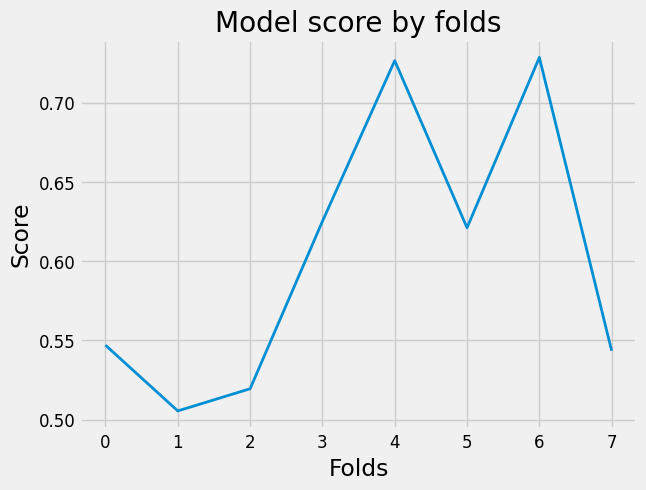

In [37]:
if not CFG.optimize and train_test == "fold":
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores, linewidth=2)

    plt.title("Model score by folds")
    plt.xlabel("Folds")
    plt.xticks(fontsize=12)
    plt.ylabel("Score")
    plt.yticks(fontsize=12)

    plt.show()

### Backtest model

I don't consider funding fees because the can be both positive and negative. I can do it because typical funding fee is positive and majority of my trade are shorts, so I can even earn on funding. But I think it's better not to consider it at all.


  0%|          | 0/7579 [00:00<?, ?it/s]

Result balance increase is 963.1400000000001%


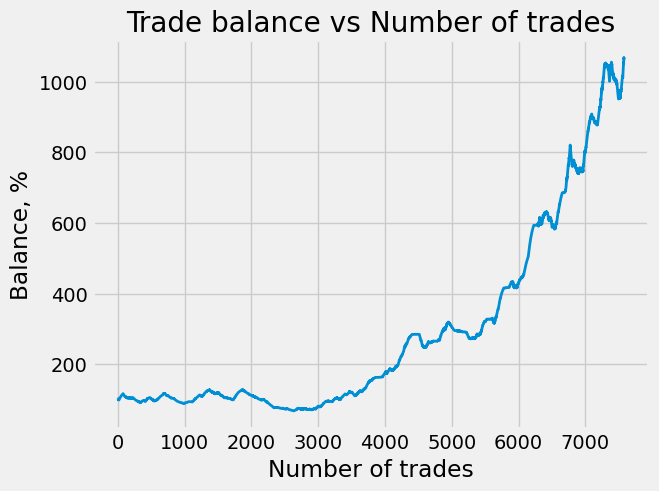

In [38]:
result, backtest_df = backtest(train_df, oof, val_idxs, high_bound, show_progress=True)
    
# plot the balance
backtest_plot = backtest_df["balance"].reset_index(drop=True)
backtest_plot = backtest_plot * 100

print(f"Result balance increase is {result - 100}%")

plt.xlabel('Number of trades')
plt.ylabel('Balance, %')
plt.title('Trade balance vs Number of trades')
backtest_plot.plot(linewidth=2);

### Display PR curve for fold predictions

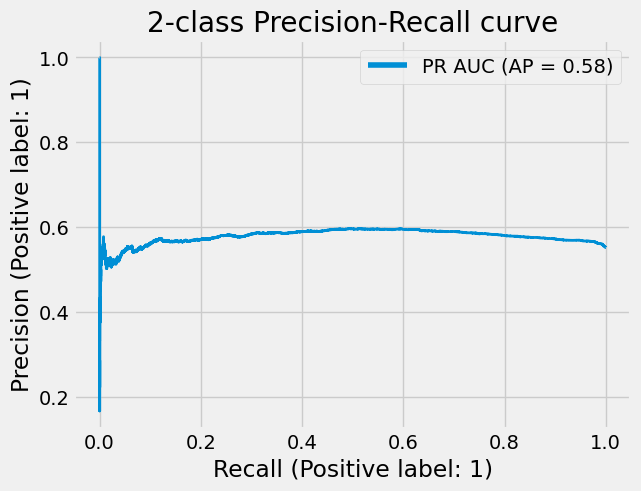

In [39]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == "fold":
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc="upper right")
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold for fold predictions

ic| bound: 0.41
    score: 0.58185
    obj_num: 9652
    obj_pct: 0.75
    obj_profit

: 1580
ic| bound: 0.411
    score: 0.58198
    obj_num: 9636
    obj_pct: 0.75
    obj_profit: 1580
ic| bound: 0.412
    score: 0.58218
    obj_num: 9619
    obj_pct: 0.74
    obj_profit: 1581
ic| bound: 0.413
    score: 0.5823
    obj_num: 9593
    obj_pct: 0.74
    obj_profit: 1579
ic| bound: 0.414
    score: 0.58218
    obj_num: 9564
    obj_pct: 0.74
    obj_profit: 1572
ic| bound: 0.415
    score: 0.58228
    obj_num: 9547
    obj_pct: 0.74
    obj_profit: 1571
ic| bound: 0.416
    score: 0.58233
    obj_num: 9529
    obj_pct: 0.74
    obj_profit: 1569
ic| bound: 0.417
    score: 0.58254
    obj_num: 9510
    obj_pct: 0.74
    obj_profit: 1570
ic| bound: 0.418
    score: 0.58276
    obj_num: 9491
    obj_pct: 0.74
    obj_profit: 1571
ic| bound: 0.419
    score: 0.58297
    obj_num: 9467
    obj_pct: 0.73
    obj_profit: 1571
ic| bound: 0.42
    score: 0.58295
    obj_num: 9457
    obj_pct: 0.73
    obj_profit: 1569
ic| bound: 0.421
    score: 0.58312
    obj_num: 9432
    obj_pct

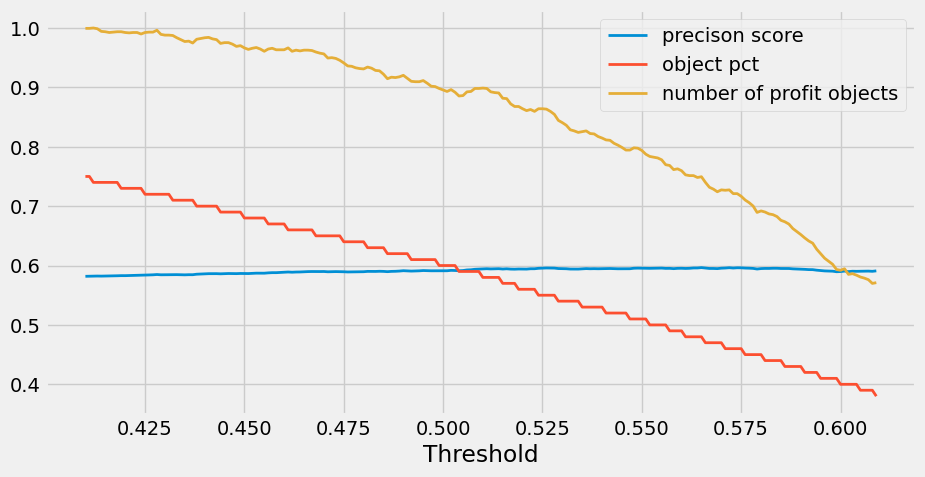

In [40]:
from icecream import ic

if not CFG.optimize and train_test == "fold":
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label="precison score", linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label="object pct", linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label="number of profit objects", linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

### Model feature importance

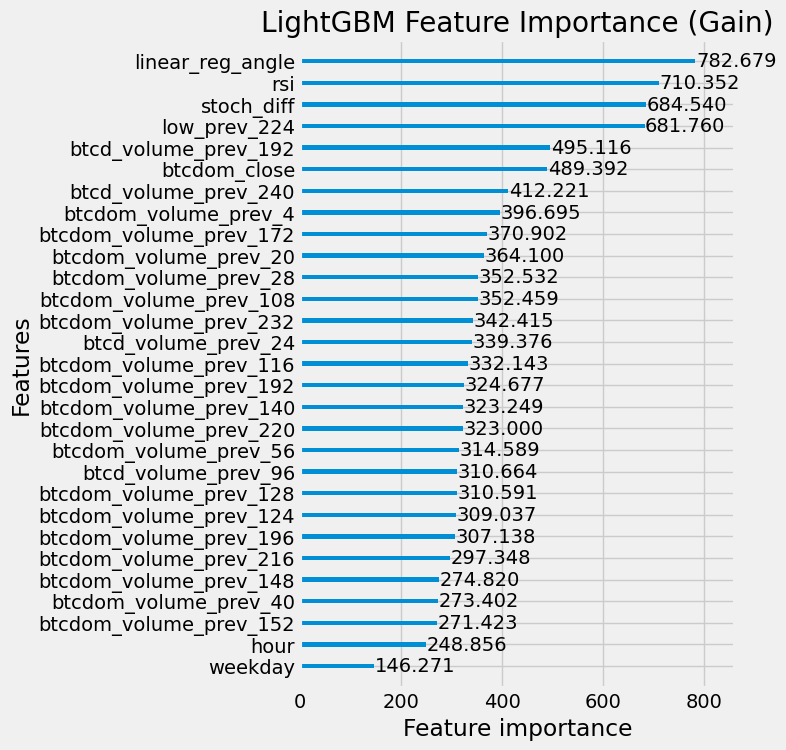

In [43]:
lgb.plot_importance(model, importance_type="gain", figsize=(5, 8), title="LightGBM Feature Importance (Gain)")
plt.show()

# Error analysis

### Distribution of model pseudo-residuals

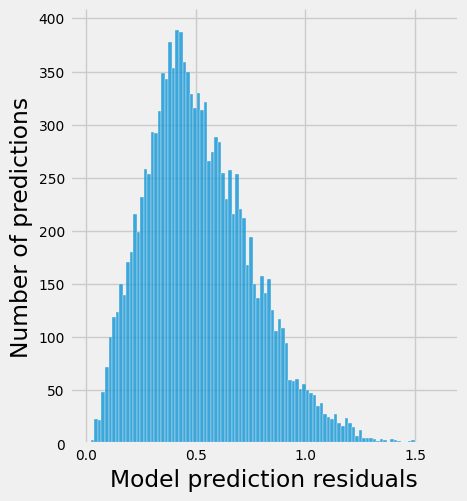

In [47]:
def logloss(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """LogLoss terms"""
    if (y_pred <= 0).any() or (y_pred >= 1).any():
        raise ValueError("y_pred must be between 0 and 1")
    if ((y_true != 0) & (y_true != 1)).any():
        raise ValueError("y_true must be 0 or 1")
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    return y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)


if not CFG.optimize and train_test == "fold":
    residual_df = train_df.loc[val_idxs, ["target"]]
    residual_df["pred"] = oof.ravel()
    y_true = residual_df["target"].values
    y_pred = residual_df["pred"].values
    residuals = -logloss(y_true, y_pred)
    residual_df["residuals"] = residuals
    
    sns.displot(np.log1p(residuals), bins=100)

    plt.xlabel("Model prediction residuals")
    plt.xticks(fontsize=10)
    plt.ylabel("Number of predictions")
    plt.yticks(fontsize=10)

### Pseudo-residuals vs Predictions plot

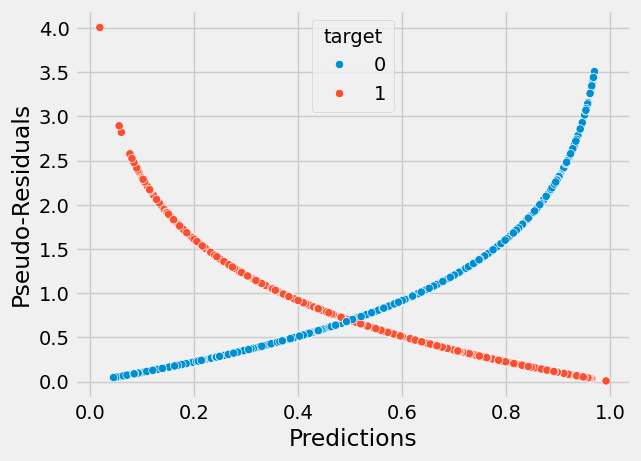

In [45]:
sns.scatterplot(residual_df, x="pred", y="residuals", hue="target")
plt.xlabel("Predictions")
plt.ylabel("Pseudo-Residuals");

### Residual stat tests

In [48]:
from stat_tests import test_normality, test_unbiased, test_homoscedasticity

display(test_normality(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is not normal
display(test_unbiased(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is biased
display(test_homoscedasticity(y_true, y_pred, bins=30, alpha=0.05)) # p-value < 0.05 -> residuals distribution is heteroscedastic

p-value may not be accurate for N > 5000.


(0.0, True)

(0.022329229183438087, True)

(0.0, True)

### Show worst predictions

In [49]:
worst_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(20).index
worst_idxs_df = train_df.loc[worst_idxs, ["time", "ticker", "target", "ttype"]]
worst_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(20)["pred"]
worst_idxs_df

,time,ticker,target,ttype,pred
15556,2023-04-22 03:00:00,STXUSDT,0,buy,0.970025
20153,2023-09-18 03:00:00,MINAUSDT,0,buy,0.968003
17496,2023-06-19 01:00:00,LOOKSUSDT,0,buy,0.967863
15587,2023-04-24 00:00:00,IDUSDT,0,buy,0.967297
15045,2023-04-09 18:00:00,LQTYUSDT,0,buy,0.966024
20148,2023-09-18 02:00:00,OMGUSDT,0,buy,0.964782
15560,2023-04-22 03:00:00,GMXUSDT,0,buy,0.964168
31646,2024-05-16 11:00:00,DAOUSDT,0,sell,0.961613
15095,2023-04-11 05:00:00,CFXUSDT,0,sell,0.957398
16821,2023-05-29 09:00:00,UNIUSDT,0,sell,0.956749


### Show best predictions

In [50]:
best_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals").head(20).index
best_idxs_df = train_df.loc[best_idxs, ["time", "ticker", "target", "ttype"]]
best_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals").head(20)["pred"]
best_idxs_df

,time,ticker,target,ttype,pred
14575,2023-03-25 18:00:00,STXUSDT,1,buy,0.992270
14507,2023-03-23 01:00:00,CROUSDT,1,buy,0.965479
16423,2023-05-19 00:00:00,ALGOUSDT,1,buy,0.963650
26942,2024-03-18 23:00:00,XAIUSDT,1,buy,0.960995
26946,2024-03-18 23:00:00,CELOUSDT,1,buy,0.959318
26981,2024-03-19 01:00:00,1000BONKUSDT,1,buy,0.957439
14696,2023-03-29 05:00:00,CFXUSDT,1,sell,0.956266
15118,2023-04-11 11:00:00,AAVEUSDT,1,sell,0.954112
15910,2023-05-06 15:00:00,ZENUSDT,1,buy,0.953757
20150,2023-09-18 02:00:00,RSRUSDT,1,buy,0.953451


# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- ticker price doesn't reach the cls_target_ratio_tp or cls_target_ratio_sl thresholds yet

- errors in the data preparation pipeline make model give different predictions

- bot was used in debug mode

- too small volume

- ticker is not presented in bybit_ticker_list due to errors

- ticker was added to exchange not too much time ago

- different high_bound threshold

- there are NaNs in the ticker dataframe

- signal was one of the last in the dataframe and was deleted due to signal error protection measures

In [51]:
if not CFG.optimize:
    if train_test == "test":
        model = joblib.load("model/lgbm.pkl")
        with open(f"model/features.json", "r") as f:
            features = json.load(f)["features"]

    with open(f"model/bybit_tickers.json", "r") as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df["ticker"].isin(bybit_tickers))]
    X["pred_proba"] = model.predict_proba(X[features])[:,1]
    res = X.loc[((X["pred_proba"] >= high_bound)) & (X["time"] > CFG.last_date), ["time", "ticker", "ttype", "pred_proba", "target", "pattern"]]
    res = res.reset_index(drop=True)
    display(res["time"].min(), res["time"].max())
    display(res["target"].value_counts())
    display(res["target"].value_counts(normalize=True))
    display(res)

Timestamp('2024-09-16 20:00:00')

Timestamp('2024-09-23 01:00:00')

1    59
0    51
Name: target, dtype: int64

1    0.536364
0    0.463636
Name: target, dtype: float64

,time,ticker,ttype,pred_proba,target,pattern
0,2024-09-16 20:00:00,ALPHAUSDT,buy,0.698179,0,STOCH_RSI_Volume24
1,2024-09-16 20:00:00,CHESSUSDT,buy,0.534492,0,STOCH_RSI_Volume24
2,2024-09-16 20:00:00,NEIROETHUSDT,buy,0.585303,1,STOCH_RSI_Volume24
3,2024-09-16 21:00:00,DGBUSDT,buy,0.589306,0,STOCH_RSI_Volume24
4,2024-09-16 21:00:00,RENUSDT,buy,0.563241,0,STOCH_RSI_Volume24
5,2024-09-16 22:00:00,OGNUSDT,buy,0.671331,0,STOCH_RSI_Volume24
6,2024-09-16 22:00:00,ZRXUSDT,buy,0.574023,0,STOCH_RSI_Volume24
7,2024-09-16 22:00:00,PIRATEUSDT,buy,0.648550,0,STOCH_RSI_Volume24
8,2024-09-16 22:00:00,VANRYUSDT,buy,0.574751,0,STOCH_RSI_Volume24
9,2024-09-16 22:00:00,NOTUSDT,buy,0.599343,0,STOCH_RSI_Volume24


### Plot rolling mean ppv_npv_acc score of the model predictions for the new data

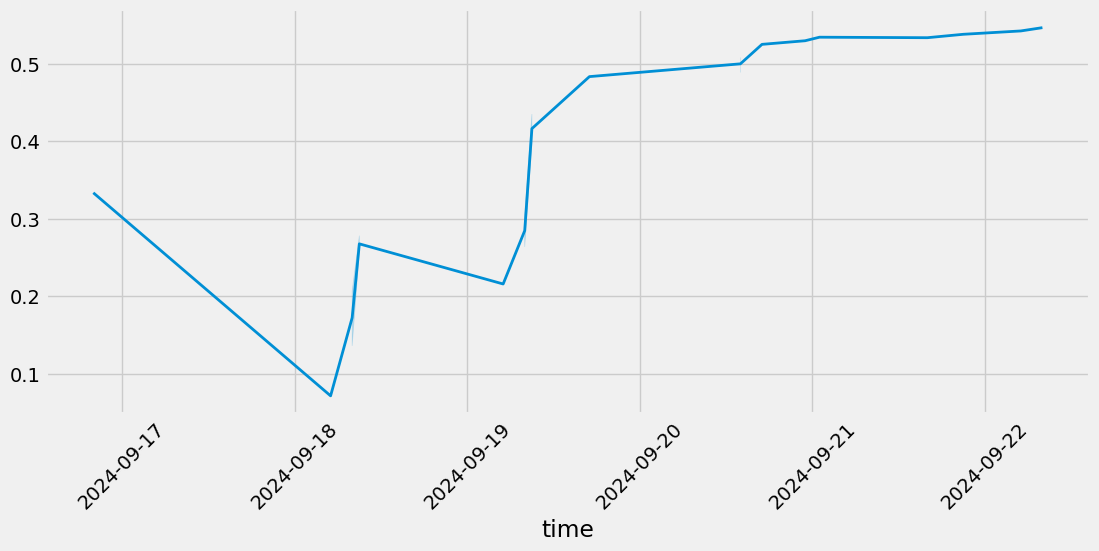

In [52]:
if not CFG.optimize:
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res["target"] == 1]
    
    if len(tmp) > 0:
        tmp["ppv_npv_acc"] = tmp["target"].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

        ax = sns.lineplot(x=tmp["time"], y=tmp["ppv_npv_acc"].values)
        ax.lines[0].set_linewidth(2)
        plt.xticks(rotation=45);

# Compare indicator / signal values for bot and optimizer

In [ ]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = "sell"
# ticker = "BADGERUSDT"
# month = 7
# day = 15
# hour = 23
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)
# y = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, "", "", 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, "", "", 0)

# # cols = ["time", "open", "high", "low", "close", "volume", "rsi", "stoch_slowk", "stoch_slowd", "linear_reg", "linear_reg_angle", "macd", "macdsignal", "macdhist"]
# cols = ["time", "open", "high", "low", "close", "volume", "linear_reg", "linear_reg_angle", "high_max", "low_min", "volume_24"]

# higher_features = ["time_4h", "linear_reg", "linear_reg_angle", "macd", "macdhist",  "macd_dir", 
#                    "macdsignal", "macdsignal_dir"]
# x["time"] = pd.to_datetime(x["time"])
# y["time"] = pd.to_datetime(y["time"])
# y["time_4h"] = y["time"] + pd.to_timedelta(3, unit="h")
# x[["time"] + higher_features] = pd.merge(x[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# # x = x.drop(columns=["time_4h"])
# # y = y.drop(columns=["time_4h"])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
# v = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, "", "", 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, "", "", 0)
# z.tail(48)

# v["time_4h"] = v["time"] + pd.to_timedelta(3, unit="h")
# z[["time"] + higher_features] = pd.merge(z[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# z = z.drop(columns=["time_4h"])
# v = v.drop(columns=["time_4h"])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols])